# NMF Code

## count2matrix
- generate the H and W matrix from single cell count matrix 

`cd /public/workspace202011/pancancer/chaohy/NMF_count/k10`

`for i in $(ls *.count.txt); do `  
`    python /public/workspace202011/pancancer/chaohy/scripts/auto_nmf.py `  
`    --input ./${i} `  
`    --output_w ./${i%%.*}_W.txt `  
`    --output_h ./${i%%.*}_H.txt `  
`    --rank_min 1 --rank_max 10 -n 3000`  
`done`

## matrix2heatmap

In [2]:
library(tidyr)
library(ggplot2)
library(dplyr)
library(stringr)
library(clusterProfiler)
library(fgsea)
library(org.Hs.eg.db)
library(xlsx)

In [3]:
setwd("/public/workspace202011/pancancer/chaohy/joLncPDAC/countK10")

In [4]:
list.files(path = ".", pattern = ".count.txt$") %>% head() # count: cell * gene
list.files(path = ".", pattern = "_W.txt$") %>% head() # W: cell * program
list.files(path = ".", pattern = "_H.txt$") %>% head() # H: program * gene

[1] "Case1-YF.count.txt" "Case1-ZY.count.txt" "Case2-YF.count.txt"
[4] "Case2-ZY.count.txt" "Case3-YF.count.txt" "Case3-ZY.count.txt"

[1] "Case1-YF_W.txt" "Case1-ZY_W.txt" "Case2-YF_W.txt" "Case2-ZY_W.txt"
[5] "Case3-YF_W.txt" "Case3-ZY_W.txt"

[1] "Case1-YF_H.txt" "Case1-ZY_H.txt" "Case2-YF_H.txt" "Case2-ZY_H.txt"
[5] "Case3-YF_H.txt" "Case3-ZY_H.txt"

### W matrix (cell * program) processing  
- output normalized W matrix

In [5]:
# W: cell * program
cell_gp_list <- list.files(path = ".", pattern = "_W.txt$")
for (i in cell_gp_list) {
  print(strsplit(i, "_")[[1]][1])
  }

[1] "Case1-YF"
[1] "Case1-ZY"
[1] "Case2-YF"
[1] "Case2-ZY"
[1] "Case3-YF"
[1] "Case3-ZY"
[1] "Case4-YF"
[1] "Case4-ZY"
[1] "Case5-YF"
[1] "Case5-ZY"
[1] "Case6-ZY"
[1] "LM1"
[1] "PT1"
[1] "PT2"
[1] "PT3"
[1] "PT4"
[1] "PT5"
[1] "T1"
[1] "T10"
[1] "T11"
[1] "T12"
[1] "T13"
[1] "T14"
[1] "T15"
[1] "T16"
[1] "T17"
[1] "T18"
[1] "T19"
[1] "T2"
[1] "T20"
[1] "T21"
[1] "T22"
[1] "T23"
[1] "T24"
[1] "T3"
[1] "T4"
[1] "T5"
[1] "T6"
[1] "T7"
[1] "T8"
[1] "T9"


,Case3-ZY_1,Case3-ZY_2,Case3-ZY_3,Case3-ZY_4,Case3-ZY_5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Case3-ZY@@_AAACCCAGTCGTATGT-1,3.984517e-02,1.244821e-01,5.205215e-23,1.988178e-21,2.712478e-32
Case3-ZY@@_AAACCCATCCCGTAAA-1,7.970746e-02,1.801483e-01,1.120618e-46,1.528653e-01,7.316155e-18
Case3-ZY@@_AAACGAAAGGATATAC-1,1.309855e-18,1.289336e-11,1.751314e-01,2.364285e-17,8.492510e-07
Case3-ZY@@_AAACGCTTCAGCACCG-1,5.983630e-46,1.928930e-01,3.468877e-01,3.739769e-45,5.026660e-17
Case3-ZY@@_AAACGCTTCATGTCAG-1,3.491556e-04,1.641076e-34,1.568014e-01,5.577800e-03,1.802161e-08


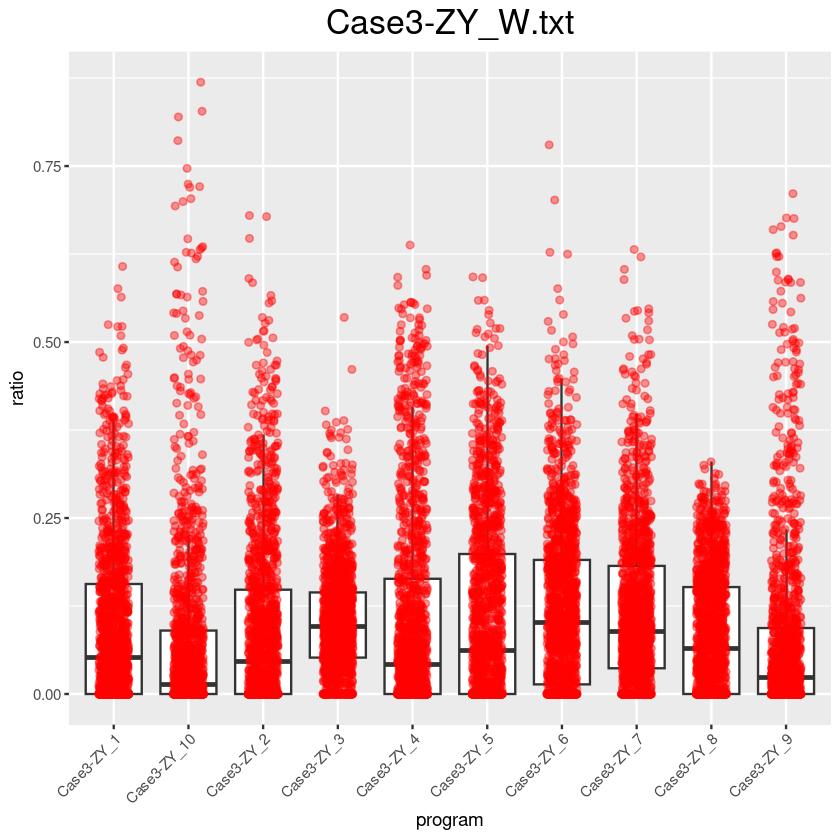

In [6]:
# demo (can skip)
i <- cell_gp_list[6]
usage.df=read.table(i,header = T,row.names = 1,sep = "\t",stringsAsFactors = F, check.names = F)
prefix <- strsplit(i, "_")[[1]][1]
colnames(usage.df) <- paste(prefix,1:dim(usage.df)[2],sep = "_")

# normalize
usage.df <- usage.df / rowSums(usage.df)
usage.df[1:5,1:5]
write.table(usage.df,file = paste(prefix,"_program.usage.norm.txt",sep = ""),quote = F,sep = "\t",row.names = T,col.names = T)

# QC1
tmpdf1=gather(usage.df,"program","ratio")
tmpdf1%>%ggplot(aes(x=program,y=ratio))+geom_boxplot(outlier.shape = NA)+geom_jitter(color="red",alpha=0.4,width = 0.2)+
    labs(title = i)+
    theme(
    axis.text.x.bottom = element_text(angle = 45,hjust = 1),
    plot.title = element_text(hjust = 0.5,size=20)
    )
ggsave(paste(prefix,"_program.usage.norm.QC.png",sep = ""),device = "png",width = 20,height = 16,units = c("cm"))

In [7]:
# batching
for (i in cell_gp_list) {
  usage.df=read.table(i,header = T,row.names = 1,sep = "\t",stringsAsFactors = F, check.names = F)
  prefix <- strsplit(i, "_")[[1]][1]
  colnames(usage.df)=paste(prefix,1:dim(usage.df)[2],sep = "_")
  
  #normalize
  usage.df=usage.df / rowSums(usage.df)
  write.table(usage.df,file = paste(prefix,"_program.usage.norm.txt",sep = ""),quote = F,sep = "\t",row.names = T,col.names = T)
  }


In [8]:
usage.df[1:5,]

,T9_1,T9_2,T9_3,T9_4,T9_5,T9_6,T9_7,T9_8,T9_9,T9_10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
T9@@_AAACCTGCATGTCGAT-1,5.966702e-02,0.163693137,0.03031297,1.163082e-01,9.916870e-02,6.624325e-03,0.31992682,0.154019823,5.027878e-02,1.762107e-07
T9@@_AAACCTGGTCACTTCC-1,1.009343e-24,0.125250711,0.10452448,1.527502e-12,8.572146e-02,2.589287e-01,0.10876284,0.092094814,2.007789e-02,2.046391e-01
T9@@_AAACCTGGTTGGTTTG-1,9.844708e-02,0.002834102,0.04288595,2.150808e-01,3.113949e-01,1.095447e-03,0.04219901,0.196641868,2.133221e-02,6.808859e-02
T9@@_AAACCTGGTTTGACTG-1,2.607680e-01,0.023759665,0.33239951,1.963366e-05,3.324510e-10,2.240216e-07,0.25459723,0.126266450,4.782522e-12,2.189268e-03
T9@@_AAACCTGTCTGCGACG-1,5.613339e-02,0.174642388,0.17142149,4.637387e-02,8.374913e-02,1.872079e-01,0.27794625,0.002524621,9.404436e-10,9.530269e-07


[1] 406

[1] 335

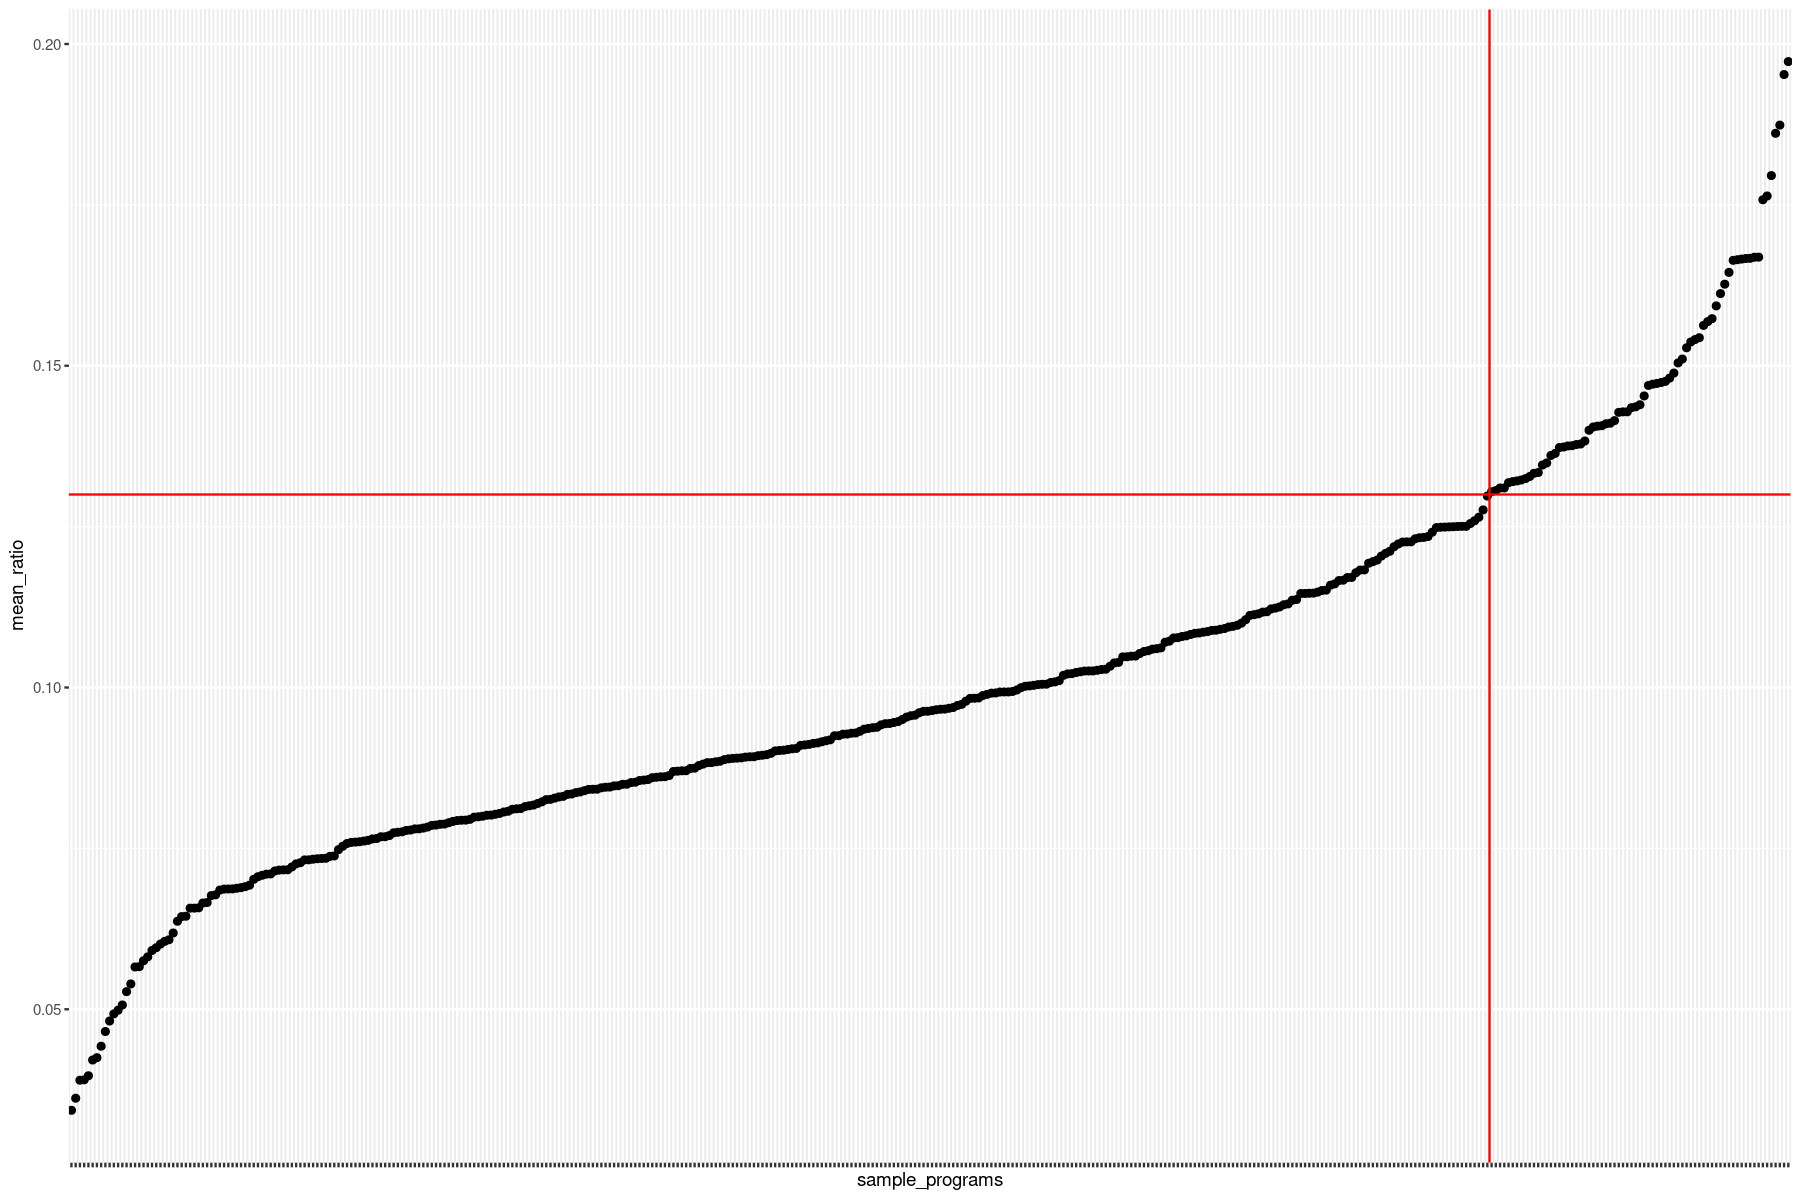

In [53]:
# filt gene program if cell usage sum is too low
usage_filter <- 0.13

program_list <- list.files(path = ".", pattern = "_program.usage.norm.txt$")
check.usage=data.frame()
for (i in program_list ) {
  usage.df=read.table(i,header = T,row.names = 1,sep = "\t",stringsAsFactors = F, check.names = F)
  check.usage=rbind(check.usage,as.data.frame(colMeans(usage.df)))
}
colnames(check.usage)=c("mean_ratio")
check.usage$sample_programs=rownames(check.usage)
check.usage=check.usage%>%arrange(mean_ratio)
check.usage$sample_programs=factor(check.usage$sample_programs,levels = check.usage$sample_programs)
linex=sum(check.usage$mean_ratio < usage_filter)
ggplot(check.usage, aes(x=sample_programs,y=mean_ratio)) +
  geom_point() +
  geom_hline(yintercept = usage_filter, color="red") +
  geom_vline(xintercept = linex+0.5, color="red") +
  theme(axis.text.x = element_blank() # hide x axis
  )
ggsave("all.check.usage.png",width = 30,height = 16,device = "png",units = "cm")
# output noise program list
maybe.bg=as.character(check.usage$sample_programs[check.usage$mean_ratio < usage_filter])
length(check.usage$sample_programs)
length(maybe.bg)

### H matrix (program * gene) processing  
- output top 50 genes for each program  
- output each gene's contribution to each program

In [12]:
# H: program * gene
gp_gene_list <- list.files(path = ".", pattern = "_H.txt$")
for (i in gp_gene_list) {
  print(strsplit(i, "_")[[1]][1])
}

[1] "Case1-YF"
[1] "Case1-ZY"
[1] "Case2-YF"
[1] "Case2-ZY"
[1] "Case3-YF"
[1] "Case3-ZY"
[1] "Case4-YF"
[1] "Case4-ZY"
[1] "Case5-YF"
[1] "Case5-ZY"
[1] "Case6-ZY"
[1] "LM1"
[1] "PT1"
[1] "PT2"
[1] "PT3"
[1] "PT4"
[1] "PT5"
[1] "T1"
[1] "T10"
[1] "T11"
[1] "T12"
[1] "T13"
[1] "T14"
[1] "T15"
[1] "T16"
[1] "T17"
[1] "T18"
[1] "T19"
[1] "T2"
[1] "T20"
[1] "T21"
[1] "T22"
[1] "T23"
[1] "T24"
[1] "T3"
[1] "T4"
[1] "T5"
[1] "T6"
[1] "T7"
[1] "T8"
[1] "T9"


In [11]:
# demo (can skip)
i <- gp_gene_list[3]
top_gene <- 50
score.df=read.table(i,header = T,row.names = 1,sep = "\t",stringsAsFactors = F, check.names = FALSE)
score.df=as.data.frame(t(score.df))
prefix <- strsplit(i, "_")[[1]][1]
colnames(score.df)=paste(prefix,1:dim(score.df)[2],sep = "_")

topn.df=as.data.frame(matrix(nrow = top_gene,ncol = ncol(score.df)))
colnames(topn.df)=colnames(score.df)

for (k in colnames(score.df)) {
tmpv=score.df[,k]
names(tmpv)=rownames(score.df)
tmpv <- tmpv[!grepl("^(MT|RP)", names(tmpv))]
topn.df[,k]=names(rev(tail(sort(tmpv),top_gene)))
}

#save
write.table(topn.df, file = paste(prefix,"_program.Zscore.top",top_gene,"gene.txt",sep = ""),quote = F,sep = "\t",row.names = F,col.names = T)
score.df$gene=rownames(score.df)
write.table(score.df,file = paste(prefix,"_program.Zscore.txt",sep = ""),quote = F,sep = "\t",row.names = F,col.names = T)

topn.df[1:5,1:5]
score.df[1:5,1:5]

,Case2-YF_1,Case2-YF_2,Case2-YF_3,Case2-YF_4,Case2-YF_5
,<chr>,<chr>,<chr>,<chr>,<chr>
1,MALAT1,S100A6,CEACAM5,MALAT1,KRT19
2,HSPA1A,HSALNG0136337,S100A6,FTH1,MALAT1
3,HSALNG0136337,TMSB4X,MALAT1,FTL,PTMA
4,HSPA1B,FTH1,HSALNG0136337,H2AFZ,KRT18
5,JUN,HSALNG0069466,KRT19,PTMA,KRT8


,Case2-YF_1,Case2-YF_2,Case2-YF_3,Case2-YF_4,Case2-YF_5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HSALNG0000002,0.000000000,0.000000000,0,0.001373732,0
HSALNG0000003,0.000000000,0.000000000,0,0.000000000,0
HSALNG0000004,0.000000000,0.000000000,0,0.000000000,0
HSALNG0000014,0.000000000,0.000000000,0,0.000000000,0
HSALNG0000017,0.009058435,0.002303178,0,0.000000000,0


In [13]:
# batching (with parallel)
top_gene <- 100

# Load the libraries
library(foreach)
library(doParallel)

# Set the number of cores you want to use
num_cores <- 30  # You can adjust this based on the available cores

# Register parallel backend
cl <- makeCluster(num_cores)
registerDoParallel(cl)

# Define a function for processing each file
process_file <- function(i) {
  score.df <- read.table(i, header = TRUE, row.names = 1, sep = "\t", stringsAsFactors = FALSE, check.names = F)
  score.df <- as.data.frame(t(score.df))
  prefix <- strsplit(i, "_")[[1]][1]
  colnames(score.df) <- paste(prefix, 1:ncol(score.df), sep = "_")
  topn.df <- as.data.frame(matrix(nrow = top_gene, ncol = ncol(score.df)))
  colnames(topn.df) <- colnames(score.df)
  for (k in colnames(score.df)) {
    tmpv <- score.df[, k]
    names(tmpv) <- rownames(score.df)
    tmpv <- tmpv[!grepl("^(MT|RP)", names(tmpv))] # 此处选择是否过滤线粒体和核糖体蛋白基因
    topn.df[, k] <- names(rev(tail(sort(tmpv), top_gene)))
  }
 
  # Save
  write.table(topn.df, file = paste(prefix, "_program.Zscore.top", top_gene, "gene.txt", sep = ""), quote = FALSE, sep = "\t", row.names = FALSE, col.names = TRUE)
  score.df$gene <- rownames(score.df)
  write.table(score.df, file = paste(prefix, "_program.Zscore.txt", sep = ""), quote = FALSE, sep = "\t", row.names = FALSE, col.names = TRUE)
}

# Apply the function to the list of files in parallel
foreach(i = gp_gene_list, .combine = 'rbind') %dopar% process_file(i)

# Stop the parallel backend
stopCluster(cl)


Loading required package: iterators



NULL

In [116]:
# # batching (no parallel)
# top_gene <- 100

# for (i in gp_gene_list) {
#   score.df=read.table(i,header = T,row.names = 1,sep = "\t",stringsAsFactors = F, check.names = F)
#   score.df=as.data.frame(t(score.df))
#   prefix <- strsplit(i, "_")[[1]][1]
#   colnames(score.df)=paste(prefix,1:dim(score.df)[2],sep = "_")
#   topn.df=as.data.frame(matrix(nrow = top_gene, ncol = ncol(score.df)))
#   colnames(topn.df)=colnames(score.df)
#   for (k in colnames(score.df)) {
#     tmpv=score.df[,k]
#     names(tmpv)=rownames(score.df)
#     tmpv = tmpv[!grepl("^(MT|RP)", names(tmpv))]
#     topn.df[,k]=names(rev(tail(sort(tmpv),top_gene)))
#   }
#   #save
#   write.table(topn.df, file = paste(prefix,"_program.Zscore.top",top_gene,"gene.txt",sep = ""),quote = F,sep = "\t",row.names = F,col.names = T)
#   score.df$gene=rownames(score.df)
#   write.table(score.df,file = paste(prefix,"_program.Zscore.txt",sep = ""),quote = F,sep = "\t",row.names = F,col.names = T)
# }

In [61]:
# merge all program Zscore by full join gene
all.score.df=data.frame()
program_Zscore_list <- list.files(path = ".", pattern = "_program.Zscore.txt$")
for (i in program_Zscore_list) {
  score.df=read.table(i,header = T,sep = "\t",stringsAsFactors = F, check.names = F)
  if (i==program_Zscore_list[1]) {all.score.df=score.df}
  if (i!=program_Zscore_list[1]) {
    all.score.df=all.score.df %>% full_join(score.df,by="gene") # 全合并不用担心NA值，后面使用pairwise.complete.obs可以避免计算NA
  }
}
rownames(all.score.df)=all.score.df$gene
all.score.df$gene=NULL
write.table(all.score.df,file = "all.program_Zscore.txt",quote = F,sep = "\t",row.names = T,col.names = T)

In [62]:
dim(all.score.df)
all.score.df[1:5,]
tail(all.score.df)

[1] 62356   406

,Case1-YF_1,Case1-YF_2,Case1-YF_3,Case1-YF_4,Case1-YF_5,Case1-YF_6,Case1-YF_7,Case1-YF_8,Case1-YF_9,Case1-YF_10,⋯,T9_1,T9_2,T9_3,T9_4,T9_5,T9_6,T9_7,T9_8,T9_9,T9_10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HSALNG0000002,1.000000e-45,4.0000e-45,0.0011221926,3.000000e-45,1.486048e-03,3.431585e-04,3.237190e-29,1e-45,3e-45,0.0016005876,⋯,3.033104e-27,1.000000e-45,0.0022468588,0.001325456,6e-45,0.0005319212,1e-45,0.003150878,2.890000e-43,3.184026e-18
HSALNG0000003,7.985494e-05,7.9246e-05,0.0003284086,3.796881e-04,1.000000e-45,1.000000e-45,9.471433e-25,1e-45,1e-45,0.0003168569,⋯,1.512487e-04,4.535115e-11,0.0002397478,0.000000000,1e-45,0.0001834274,0e+00,0.000000000,4.045595e-04,1.659256e-23
HSALNG0000004,1.297180e-19,1.0000e-45,0.0007611891,3.351131e-04,3.000000e-45,1.000000e-45,2.293250e-07,1e-45,3e-45,0.0003388220,⋯,0.000000e+00,0.000000e+00,0.0000000000,0.000000000,0e+00,0.0000000000,0e+00,0.000000000,0.000000e+00,0.000000e+00
HSALNG0000014,0.000000e+00,0.0000e+00,0.0000000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0e+00,0e+00,0.0000000000,⋯,0.000000e+00,0.000000e+00,0.0000000000,0.000000000,0e+00,0.0000000000,0e+00,0.000000000,0.000000e+00,0.000000e+00
HSALNG0000017,3.000000e-45,0.0000e+00,0.0019846520,4.000000e-45,1.000000e-45,1.000000e-45,3.000000e-45,1e-45,3e-45,0.0017546830,⋯,0.000000e+00,1.789561e-34,0.0011994797,0.000000000,0e+00,0.0000000000,0e+00,0.000000000,0.000000e+00,5.372637e-05


,Case1-YF_1,Case1-YF_2,Case1-YF_3,Case1-YF_4,Case1-YF_5,Case1-YF_6,Case1-YF_7,Case1-YF_8,Case1-YF_9,Case1-YF_10,⋯,T9_1,T9_2,T9_3,T9_4,T9_5,T9_6,T9_7,T9_8,T9_9,T9_10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HSALNG0140975,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
HSALNG0141216,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
HSALNG0141377,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
HSALNG0141415,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
HSALNG0141430,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
HSALNG0141576,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [63]:
# merege all program top50gene
all.score.topn.df=data.frame()
top50gene_list <- list.files(path = ".", pattern = paste0("top",top_gene,"gene.txt$"))
for (i in top50gene_list) {
  score.topn.df=read.table(i,header = T,sep = "\t",stringsAsFactors = F, check.names = F)
  if (i==top50gene_list[1]) {all.score.topn.df=score.topn.df}
  if (i!=top50gene_list[1]) {
    all.score.topn.df=cbind(all.score.topn.df,score.topn.df)
  }
}

In [64]:
dim(all.score.topn.df)
all.score.topn.df[1:5,]

[1] 100 406

,Case1-YF_1,Case1-YF_2,Case1-YF_3,Case1-YF_4,Case1-YF_5,Case1-YF_6,Case1-YF_7,Case1-YF_8,Case1-YF_9,Case1-YF_10,⋯,T9_1,T9_2,T9_3,T9_4,T9_5,T9_6,T9_7,T9_8,T9_9,T9_10
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,PTMA,HSPA1A,HSALNG0136337,TFF2,S100A6,S100A6,HSALNG0069466,MALAT1,MALAT1,MALAT1,⋯,FTH1,REG1A,MALAT1,S100A6,FTH1,SERPINA3,FTH1,MMP7,KRT19,MALAT1
2,LYZ,JUN,MALAT1,TFF1,S100A11,IFI27,EEF1B2,LYZ,HSALNG0136337,HSALNG0136337,⋯,FOS,SPINK1,HSALNG0136337,SH3BGRL3,MALAT1,SERPINA1,TMSB4X,SERPINA1,S100A9,TSC22D3
3,HSALNG0136337,FOS,HSALNG0136336,PHGR1,TM4SF1,TFF1,FTH1,HSALNG0136337,TMSB4X,NEAT1,⋯,DUSP1,HLA.DRA,HSALNG0136341,ANXA2,FTL,HSALNG0091166,MALAT1,SPINK1,S100A6,JUN
4,HMGB1,HSPA1B,S100A6,C15orf48,MALAT1,AGR2,HSALNG0008545,HSALNG0136336,NTS,XIST,⋯,JUN,MMP7,S100A6,KRT8,HSALNG0069466,KRT19,S100A6,MALAT1,MALAT1,DUSP1
5,HIST1H4C,ATF3,HSALNG0136341,TFF3,S100A10,KRT19,TPT1,FOS,LYZ,S100A6,⋯,SAA1,HLA.DRB1,TMSB4X,S100A10,MIF,HSPB1,PTMA,SYT8,CRABP2,TMC5


## 尝试jaccard index。不尝试的话直接做后面的 heatmap 就行了

In [65]:
dim(all.score.topn.df)
# 过滤掉使用率低的program
all.score.topn.df <- all.score.topn.df[,setdiff(colnames(all.score.topn.df),maybe.bg)]
# all.score.topn.df <- all.score.topn.df[1:50,]
dim(all.score.topn.df)

[1] 100 406

[1] 100  71

In [66]:
# 创建一个函数计算Jaccard指数
jaccard_index <- function(x, y) {
  #  if (identical(x, y)) {
  #   return(0)  # 如果是自身，设为0
  # }
  intersection <- length(intersect(x, y))
  union <- length(unique(c(x, y)))
  return(intersection)
}

# 初始化一个矩阵用于存储Jaccard指数，同时定义行和列的名称
colNum <- length(colnames(all.score.topn.df))
jaccard_matrix <- matrix(NA, nrow = colNum, ncol = colNum)
rownames(jaccard_matrix) <- colnames(jaccard_matrix) <- colnames(all.score.topn.df)

# 计算两两列之间的Jaccard指数
for (i in 1:colNum) {
  for (j in 1:colNum) {
    jaccard_matrix[i, j] <- jaccard_index(all.score.topn.df[, i], all.score.topn.df[, j])
  }
}
dim(jaccard_matrix)

[1] 71 71

In [67]:
jaccard_matrix[1:5,1:5]

,Case1-ZY_9,Case2-YF_1,Case2-YF_2,Case2-YF_6,Case2-ZY_7
Case1-ZY_9,100,17,46,34,34
Case2-YF_1,17,100,12,13,29
Case2-YF_2,46,12,100,39,32
Case2-YF_6,34,13,39,100,21
Case2-ZY_7,34,29,32,21,100


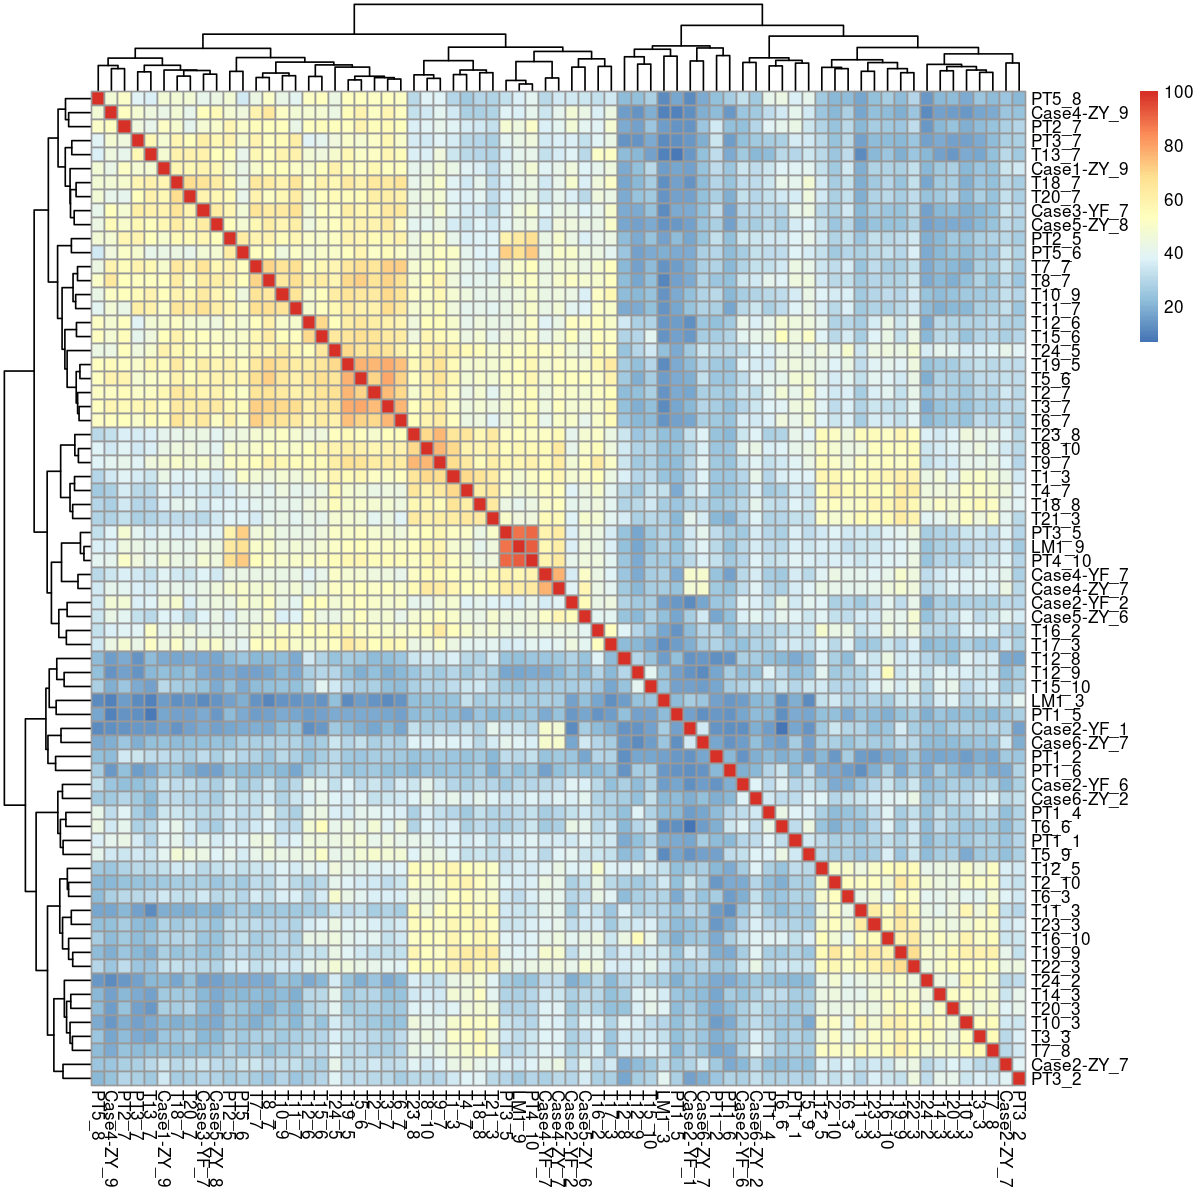

In [68]:
options(repr.plot.width=10, repr.plot.height=10)
library(pheatmap)
pheatmap(jaccard_matrix)

### heatmap

In [69]:
library(pheatmap)
library(RColorBrewer)
library(scales)

In [70]:
# all.score.df 是所有program的Zscore，all.score.rm.df 是排除了质控噪声的Zscore
dim(all.score.df)
all.score.df=all.score.df[rowSums(is.na(all.score.df)) == 0,] # 此处不用去掉，下文使用pairwise.complete.obs计算
all.score.rm.df=all.score.df[,setdiff(colnames(all.score.df),maybe.bg)] # 在质控这一步检测出来的噪声
dim(all.score.rm.df)
# write.table(all.score.df,file = "all_program.Zscore.txt",quote = F,sep = "\t",row.names = F,col.names = T)

[1] 62356   406

[1] 62356    71

In [71]:
all.score.rm.df.cor=cor(all.score.rm.df, method = "pearson", use = "pairwise.complete.obs")

In [72]:
# cor_min <- 0
# cor_max <- 1
# all.score.rm.df.cor[all.score.rm.df.cor < cor_min]=cor_min
# all.score.rm.df.cor[all.score.rm.df.cor > cor_max]=cor_max

colanno=as.data.frame(colnames(all.score.rm.df.cor))
colnames(colanno)="colnames"
colanno$sample=str_replace(colanno$colnames,"_.*","")
rownames(colanno)=colanno$colnames
colanno$colnames=NULL

rowanno=as.data.frame(rownames(all.score.rm.df.cor))
colnames(rowanno)="rownames"
rowanno$sample=str_replace(rowanno$rownames,"_.*","")
rownames(rowanno)=rowanno$rownames
rowanno$rownames=NULL

#指定注释条的颜色
color_v=colorRampPalette(RColorBrewer::brewer.pal(9, "Set1"))(length(top50gene_list))
names(color_v)=str_replace(top50gene_list,"_.*","")
ann_colors = list(sample = color_v)
# 将"."替换为"-"
colnames(all.score.rm.df.cor) <- gsub("\\.", "-", colnames(all.score.rm.df.cor))
rownames(all.score.rm.df.cor) <- gsub("\\.", "-", rownames(all.score.rm.df.cor))

# add study annotation
rowanno$study <- gsub("\\d{1}.*", "", rowanno$sample) #注意此处替换规则，如果study名字中有数字，可能需要修改
colanno$study <- gsub("\\d{1}.*", "", colanno$sample)


         Length Class  Mode   
tree_row 7      hclust list   
tree_col 7      hclust list   
kmeans   1      -none- logical
gtable   7      gtable list   

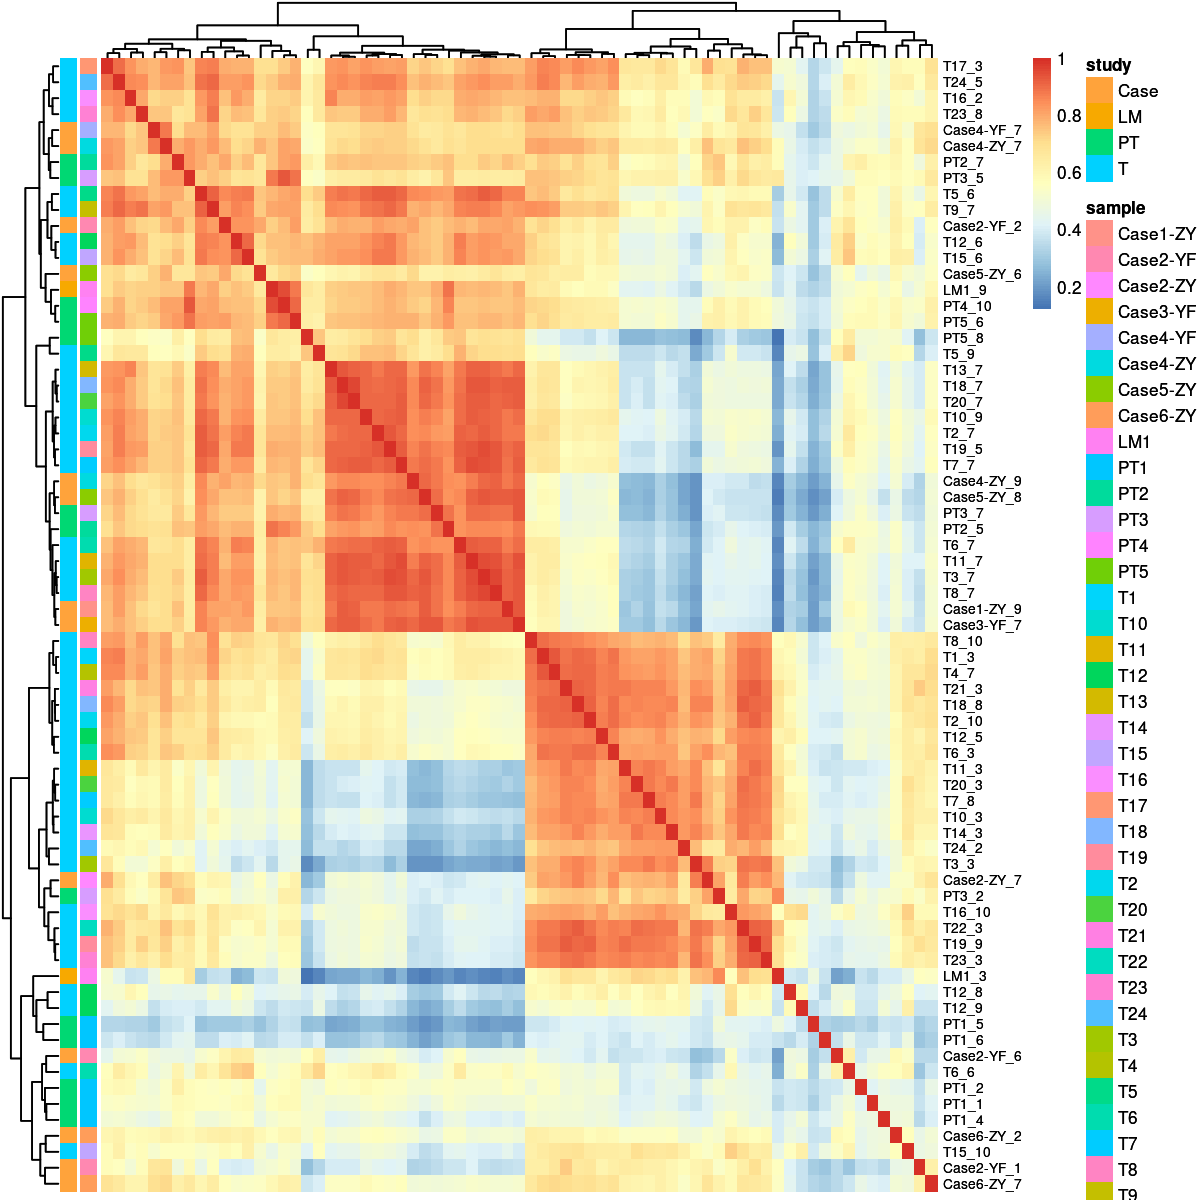

In [73]:
options(repr.plot.width=10, repr.plot.height=10)
tmpp = pheatmap(all.score.rm.df.cor,
                 cluster_rows = T,
                 cluster_cols = T,
                 clustering_method = "complete", 
                 show_colnames = F,
                 show_rownames = T,
                 treeheight_row=30,treeheight_col=30,
                 border_color= NA,
                 annotation_row = rowanno,
                 #annotation_col = colanno,
                 annotation_names_row = F,annotation_names_col = F,
                 annotation_legend = T,
                 #annotation_colors = ann_colors,
                #  color = colorRampPalette(c("white","yellow", "red","#67001F"))(50),
                 fontsize_row=8)
tmpp
summary(tmpp)

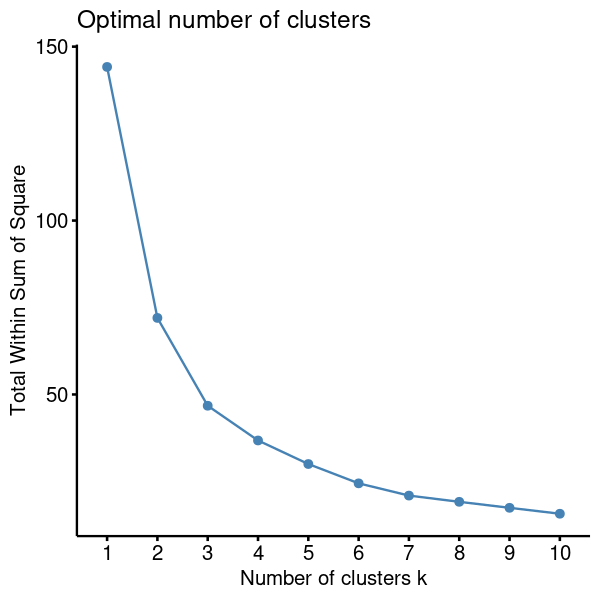

In [302]:
# 使用elbow method确定最佳聚类数目
library(factoextra)
options(repr.plot.width=5, repr.plot.height=5)
fviz_nbclust(all.score.rm.df.cor, hcut, method = "wss", k.max = 10) 

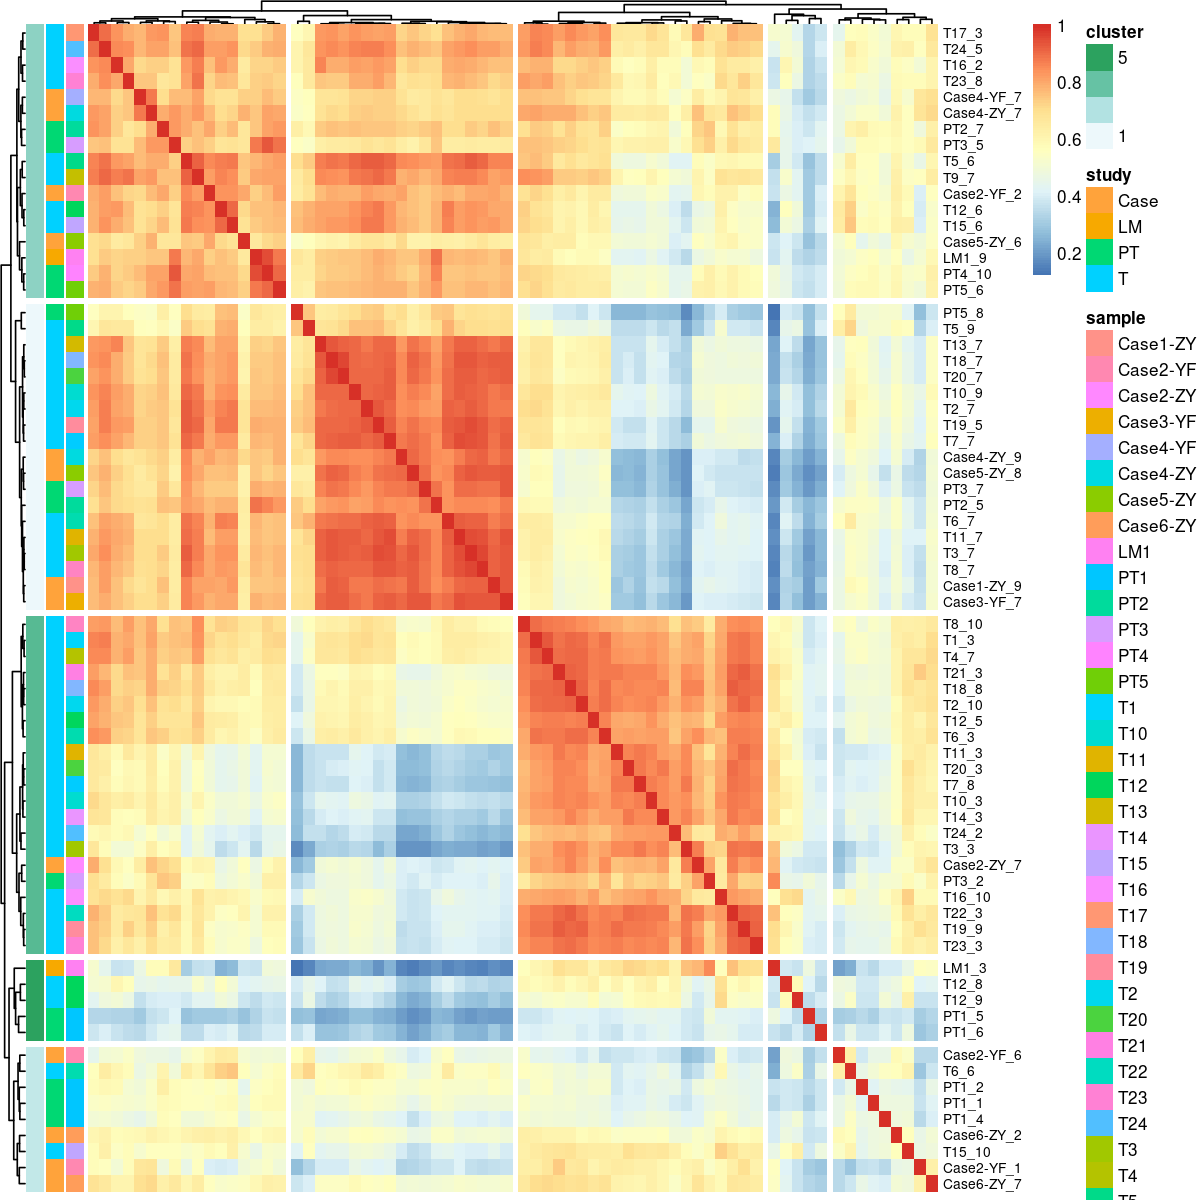

In [288]:
# 设置有多少个cluster，根据上图来设置
cluster_num <- 5
cluster_data <- as.data.frame(cutree(tmpp$tree_row, k = cluster_num))
colnames(cluster_data) <- "cluster"
rowanno$cluster <- cluster_data$cluster
colanno$cluster <- cluster_data$cluster

options(repr.plot.width=10, repr.plot.height=10)
pheatmap(all.score.rm.df.cor,
        cluster_rows = T,
        cluster_cols = T,
        cutree_rows=cluster_num,
        cutree_cols=cluster_num,
        clustering_method = "complete", 
        show_colnames = F,
        show_rownames = T,
        treeheight_row=10,treeheight_col=10,
        border_color= NA,
        annotation_row = rowanno,
        #annotation_col = colanno,
        annotation_names_row = F,annotation_names_col = F,
        annotation_legend = T,
        #annotation_colors = ann_colors,
        # color = colorRampPalette(c("white","yellow", "red","#67001F"))(50),
        fontsize_row=8)

In [78]:
# 保存画图数据
write.table(all.score.rm.df.cor,file = "all.cor_heatmap_data.txt",quote = F,sep = "\t",row.names = T,col.names = T)
# 保存program和(最相关)gene的对应关系
all.score.topn.rm.df <- all.score.topn.df[,setdiff(colnames(all.score.topn.df),maybe.bg)] # 同样从中删除检测出来的噪声
# 将数据框内容中的"."替换为"-"，也就是一些线粒体基因
all.score.topn.rm.out.df <- as.data.frame(lapply(all.score.topn.rm.df, function(x) gsub("\\.", "-", x)))
colnames(all.score.topn.rm.out.df) <- colnames(all.score.topn.rm.df)
write.table(all.score.topn.rm.out.df,file = "all.program_topngene.txt",quote = F,sep = "\t",row.names = F,col.names = T)
# 保存样本的注释信息
write.table(rowanno,file = "all.rowanno.txt",quote = F,sep = "\t",row.names = T,col.names = T)

In [79]:
# 选择感兴趣的cluster，也就是选meta program，但这个阶段依旧是盲选，
# 如果可以将聚类标号直接画在图上就好了，目前还不知道如何做，
# 只能从meta program中任意挑选一个，然后看返回的聚类结果是那个来判断
cluster_tmp <- rowanno[rownames(rowanno) == "T2_10", colnames(rowanno) == "cluster"] # 修改PDAC22_7，选择一个感兴趣的meta program
rowanno_sub <- rowanno[cluster_data$cluster == cluster_tmp, ]
rowanno_sub

,sample,study,cluster
,<chr>,<chr>,<int>
Case2-ZY_7,Case2-ZY,Case,4
PT3_2,PT3,PT,4
T1_3,T1,T,4
T10_3,T10,T,4
T11_3,T11,T,4
T12_5,T12,T,4
T14_3,T14,T,4
T16_10,T16,T,4
T18_8,T18,T,4


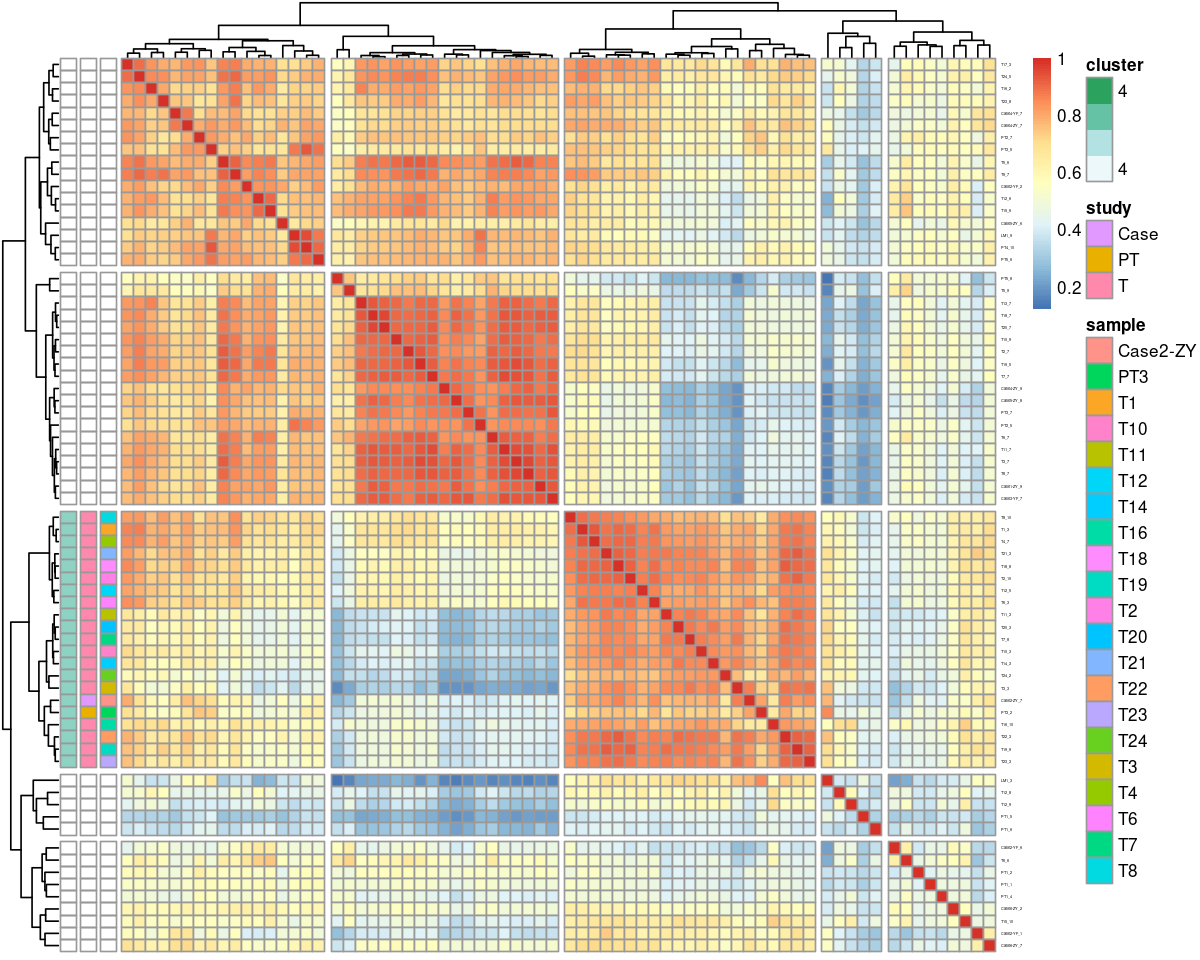

In [80]:
options(repr.plot.width=10, repr.plot.height=8)
pheatmap(all.score.rm.df.cor,
         cluster_rows = TRUE,
         cluster_cols = TRUE,
         cutree_rows=cluster_num,
         cutree_cols=cluster_num,
         # clustering_method = "complete",
         show_colnames = FALSE,
         treeheight_row = 30,
         treeheight_col = 30,
        #  border_color = "black",
         annotation_row = rowanno_sub,
         # annotation_col = colanno,
         annotation_names_row = FALSE,
         annotation_names_col = FALSE,
         annotation_legend = TRUE,
         # annotation_colors = ann_colors,
        #  color = colorRampPalette(c("yellow", "red", "#67001F"))(50),
         fontsize_row = 2,
)

### mapping

- 将热图聚类的某一群结果对应的mate program取出来，对cell打分, 就是做和细胞类型的映射，这部分先不探索

In [ ]:
# 先取出meta program的数据

/mnt/public2/pancancer/integration/PDAC.GSE205013.rds

### GSEA annotation

In [96]:
library(clusterProfiler)
library(fgsea)
library(org.Hs.eg.db)
library(xlsx)

In [45]:
# gmt annotation file
hsets <- gmtPathways("/public/workspace202011/pancancer/chaohy/gmt/hallmark_cancersea.gmt")
head(hsets,2)
# top 50 gene list
program_topn=read.table("./all.program_topngene.txt",header = T,sep = "\t",stringsAsFactors = F, check.names = F)
program_topn[1:5,]

$Angiogenesis
 [1] "ACVRL1"  "JAG1"    "ANGPT1"  "ANGPT2"  "CD34"    "CDC42"   "MAPK14" 
 [8] "TYMP"    "EDN1"    "EFNB2"   "EGR3"    "EPHB4"   "PTK2B"   "FGF2"   
[15] "FGFR1"   "VEGFD"   "FOXC2"   "FLT1"    "FLT4"    "FN1"     "GPLD1"  
[22] "NR4A1"   "ID1"     "ITGA5"   "ITGAV"   "ITGB1"   "KDR"     "LOXL2"  
[29] "MMP14"   "NOTCH1"  "PDGFA"   "PDGFRB"  "PGF"     "PIK3CA"  "PTGS2"  
[36] "PTK2"    "ROBO1"   "SHC1"    "SRF"     "TAL1"    "TDGF1"   "TEK"    
[43] "VAV2"    "VEGFA"   "VEGFC"   "FGF18"   "NRP1"    "SEMA5A"  "RAMP2"  
[50] "CIB1"    "ESM1"    "JMJD6"   "HEY1"    "ADGRA2"  "GREM1"   "SRPX2"  
[57] "SOX18"   "PARVA"   "RNF213"  "E2F8"    "RSPO3"   "OTULIN"  "E2F7"   
[64] "CCBE1"   "BMPER"   "NRARP"   "TNFAIP6" "VCAN"    "SPP1"    "CCND2"  
[71] "PIK3R1"  "STC1"    "JAG2"   

$Apoptosis
 [1] "APAF1"     "ATF4"      "ATM"       "BAK1"      "BID"       "BOK"      
 [7] "BRCA2"     "CASP2"     "CASP4"     "CASP9"     "DAPK3"     "DDIT3"    
[13] "E2F2"      "EP300"     "GSN"       "IFI16"     "INHBA"     "KRT8"     
[19] "LGALS9"    "NFATC4"    "P2RX7"     "PMAIP1"    "POLB"      "PPP2R1B"  
[25] "PPP2R5C"   "SORT1"     "SKIL"      "STK3"      "STK4"      "TIMP3"    
[31] "TNFRSF1A"  "TNFRSF1B"  "TP53BP2"   "DYRK2"     "CRADD"     "BCL10"    
[37] "AIFM1"     "BCL2L11"   "DNM1L"     "BCAP31"    "SIVA1"     "MLLT11"   
[43] "RIPK3"     "SNW1"      "PPP1R13B"  "PHLDA3"    "NUPR1"     "BBC3"     
[49] "CIDEB"     "TNFRSF21"  "PYCARD"    "CDIP1"     "G0S2"      "SHISA5"   
[55] "TNFRSF12A" "WWOX"      "DDIT4"     "USP28"     "MOAP1"     "AEN"      
[61] "TMEM109"   "APOPT1"    "BMF"       "DAB2IP"    "DEDD2"     "ST20"

,Case1-YF_2,Case1-YF_3,Case1-YF_6,Case1-YF_7,Case1-YF_8,Case1-YF_9,Case1-ZY_3,Case1-ZY_5,Case1-ZY_9,Case2-YF_1,⋯,T7_9,T7_10,T8_2,T8_3,T8_7,T8_10,T9_2,T9_5,T9_6,T9_7
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,HSPA1A,HSALNG0136337,S100A6,HSALNG0069466,MALAT1,MALAT1,HSALNG0136337,TFF2,HSALNG0069466,MALAT1,⋯,S100A6,S100A6,MALAT1,HSALNG0136336,FTH1,MALAT1,REG1A,FTH1,SERPINA3,FTH1
2,JUN,MALAT1,IFI27,EEF1B2,LYZ,HSALNG0136337,HSALNG0136336,PHGR1,EEF1B2,HSPA1A,⋯,TMSB4X,TFF1,FTH1,HSALNG0136337,TMSB4X,S100A6,SPINK1,MALAT1,SERPINA1,TMSB4X
3,FOS,HSALNG0136336,TFF1,FTH1,HSALNG0136337,TMSB4X,MALAT1,TFF1,FTH1,HSALNG0136337,⋯,PI3,MALAT1,NEAT1,HSALNG0136341,HSALNG0069466,HSALNG0136336,HLA-DRA,FTL,HSALNG0091166,MALAT1
4,HSPA1B,S100A6,AGR2,HSALNG0008545,HSALNG0136336,NTS,HSALNG0136341,TFF3,S100A6,HSPA1B,⋯,S100A10,PHGR1,LCN2,S100A6,S100A6,TMSB4X,MMP7,HSALNG0069466,KRT19,S100A6
5,ATF3,HSALNG0136341,KRT19,TPT1,FOS,LYZ,S100A6,MUC1,NME2,JUN,⋯,PTMA,LGALS4,TMSB4X,MALAT1,HSALNG0094115,FTH1,HLA-DRB1,MIF,HSPB1,PTMA


In [46]:
# 选择每个基因模块的前100个基因，并提取score值排序以满足GSEA分析
# rownames(all.score.df) <- gsub("\\.","-",rownames(all.score.df))

temp.gene.score.df <- subset(all.score.df, rownames(all.score.df) %in% program_topn$T17_5, select = c("T17_5"))
temp.gene.score.df.new <- data.frame(gene = rownames(temp.gene.score.df), score = temp.gene.score.df$T17_5)
temp.gene.score.list.order <- temp.gene.score.df.new[order(temp.gene.score.df.new$score, decreasing = TRUE),]
# GSEA基因输入
gene.score <- temp.gene.score.list.order$score
names(gene.score) <- temp.gene.score.list.order$gene
gene.score

TFF1        S100A6        TMSB4X        MALAT1 HSALNG0105532 
    0.7480823     0.7021487     0.6010185     0.5414082     0.3939890 
      S100A11      SH3BGRL3 HSALNG0136336           MIF          PTMA 
    0.3765781     0.3700845     0.3649279     0.3600019     0.3377621 
          FAU          AGR2        ATP5ME      C19orf33          FTH1 
    0.3323900     0.3074656     0.3059012     0.3037130     0.3001048 
HSALNG0069466         COX7C         UQCRQ        OCIAD2       ATP5F1E 
    0.2863371     0.2790001     0.2789088     0.2763294     0.2761012 
          TXN        SMIM22        ATP5MG        ATP5MF          TFF2 
    0.2754637     0.2686334     0.2677716     0.2644227     0.2573032 
        UBA52         GAPDH          ELOB        MRPL52        PHLDA2 
    0.2535738     0.2533737     0.2519226     0.2500228     0.2493554 
        COX7B           FTL       S100A10          CTSE          NME2 
    0.2440884     0.2418638     0.2409405     0.2397443     0.2388031 
         CFL1        UQCR11         GSTP1        CHCHD2       MICOS10 
    0.2379018     0.2358080     0.2320247     0.2291880     0.2260531 
       UQCR10          CSTB HSALNG0106470         TOMM6         COX8A 
    0.2257955     0.2257886     0.2244558     0.2236677     0.2228359 
        FXYD3 HSALNG0082038         FABP5 HSALNG0136337        LGALS3 
    0.2217442     0.2212220     0.2210138     0.2209342     0.2202478 
        PRSS2         UQCRB          GPX2          JPT1         COX6C 
    0.2194921     0.2134957     0.2132120     0.2114302     0.2112820 
      NDUFA13        S100A4         KRT19         NEAT1        ATP5MD 
    0.2076972     0.2061093     0.2060123     0.2052173     0.2032373 
       SEC61G        NDUFA3         ANXA2        NDUFA4          KRT8 
    0.2009706     0.1979039     0.1911199     0.1895909     0.1892876 
       DYNLL1          CYCS          TPM1       CEACAM6    GADD45GIP1 
    0.1873933     0.1849208     0.1837660     0.1830866     0.1825846 
HSALNG0113240        IGFBP2        COX6B1         CLIC1        NDUFA6 
    0.1821702     0.1812773     0.1806564     0.1804551     0.1766061 
       CLDN18        NDUFS6        ANXA10          UBL5          YBX1 
    0.1764002     0.1727125     0.1712215     0.1703978     0.1684935 
        H3F3A        MUC5AC         HSBP1         PRDX5        COX6A1 
    0.1682308     0.1679049     0.1670009     0.1667444     0.1646365 
       SQSTM1       PRELID1          CD24         PFDN2          TSPO 
    0.1637529     0.1623369     0.1613560     0.1590118     0.1585792 
         EIF1         S100P       ATP5MC3         SLIRP       S100A16 
    0.1552960     0.1550341     0.1545464     0.1501757     0.1485807 
        NOSIP        TSPAN8       LAMTOR5        MYL12A 
    0.1483463     0.1439673     0.1435320     0.1405523

In [47]:
# GSEA anaotation demo (can skip)
fgseaRes <- fgsea(hsets, gene.score, nperm = 10000, minSize = 1, maxSize = 500, nproc = 4)
fgseaRes[order(fgseaRes$size, decreasing = TRUE),]

Warning message in fgsea(hsets, gene.score, nperm = 10000, minSize = 1, maxSize = 500, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“All values in the stats vector are greater than zero and scoreType is "std", maybe you should switch to scoreType = "pos".”


pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
OXIDATIVE_PHOSPHORYLATION,0.84229927,0.9820427,0.1813894,0.6700937,7311,20,"ATP5ME , COX7C , UQCRQ , ATP5F1E, ATP5MG , ATP5MF , COX7B , UQCR11 , UQCR10 , COX8A , UQCRB , COX6C , NDUFA3 , NDUFA4 , CYCS , COX6B1 , NDUFA6 , NDUFS6"
Metastasis,0.81703092,0.9820427,0.2542954,0.7110676,6130,8,"MIF , AGR2"
ADIPOGENESIS,0.30673809,0.9784192,0.4499014,1.1345508,2175,6,"UQCRQ , COX7B , UQCR11, UQCR10, COX8A"
HYPOXIA,0.91935016,0.9820427,0.2550228,0.6049870,6337,5,"MIF , GAPDH , S100A4, ANXA2"
ESTROGEN_RESPONSE_LATE,0.22048158,0.9554202,0.5167798,1.2259495,1519,5,"TFF1, AGR2"
Stemness,0.12335799,0.9554202,0.6170285,1.3554387,816,4,"MALAT1, PTMA"
REACTIVE_OXYGEN_SPECIES_PATHWAY,0.88358750,0.9820427,0.3019404,0.6632784,5851,4,"TXN, FTL"
Proliferation,0.64186414,0.9820427,0.4290263,0.8579568,4062,3,MIF
TNFA_SIGNALING_VIA_NFKB,0.54815214,0.9820427,-0.4363063,-0.9309421,2031,3,"EIF1 , SQSTM1"


In [51]:
# KEGG anotation demo (can skip)
hsets.kegg <- read.gmt("/public/workspace202011/pancancer/chaohy/gmt/hallmark_cancersea.gmt")
tmp <- enricher(temp.gene.score.list.order[,1], TERM2GENE = hsets.kegg, pvalueCutoff = 1, pAdjustMethod = "BH", qvalueCutoff = 1, minGSSize = 1, maxGSSize = 500)
tmp@result %>% head(10)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
OXIDATIVE_PHOSPHORYLATION,OXIDATIVE_PHOSPHORYLATION,OXIDATIVE_PHOSPHORYLATION,20/58,200/4857,3.575621e-14,1.394492e-12,1.317334e-12,ATP5ME/COX7C/UQCRQ/ATP5F1E/ATP5MG/ATP5MF/COX7B/UQCR11/UQCR10/COX8A/UQCRB/COX6C/NDUFA3/NDUFA4/CYCS/COX6B1/NDUFA6/NDUFS6/COX6A1/ATP5MC3,20
Metastasis,Metastasis,Metastasis,8/58,166/4857,7.013621e-04,1.367656e-02,1.291983e-02,MIF/AGR2/LGALS3/S100A4/KRT19/ANXA2/CLIC1/CD24,8
REACTIVE_OXYGEN_SPECIES_PATHWAY,REACTIVE_OXYGEN_SPECIES_PATHWAY,REACTIVE_OXYGEN_SPECIES_PATHWAY,4/58,49/4857,2.600708e-03,3.380921e-02,3.193853e-02,TXN/FTL/NDUFA6/LAMTOR5,4
ADIPOGENESIS,ADIPOGENESIS,ADIPOGENESIS,6/58,200/4857,3.086053e-02,3.008902e-01,2.842417e-01,UQCRQ/COX7B/UQCR11/UQCR10/COX8A/COX6A1,6
CHOLESTEROL_HOMEOSTASIS,CHOLESTEROL_HOMEOSTASIS,CHOLESTEROL_HOMEOSTASIS,3/58,74/4857,5.771933e-02,4.335783e-01,4.095881e-01,S100A11/FABP5/LGALS3,3
Proliferation,Proliferation,Proliferation,3/58,88/4857,8.708156e-02,4.335783e-01,4.095881e-01,MIF/IGFBP2/CD24,3
ESTROGEN_RESPONSE_LATE,ESTROGEN_RESPONSE_LATE,ESTROGEN_RESPONSE_LATE,5/58,200/4857,8.893914e-02,4.335783e-01,4.095881e-01,TFF1/AGR2/FABP5/COX6C/KRT19,5
HYPOXIA,HYPOXIA,HYPOXIA,5/58,200/4857,8.893914e-02,4.335783e-01,4.095881e-01,MIF/GAPDH/S100A4/ANXA2/PRDX5,5
ANDROGEN_RESPONSE,ANDROGEN_RESPONSE,ANDROGEN_RESPONSE,3/58,100/4857,1.163415e-01,5.041463e-01,4.762516e-01,KRT19/KRT8/MYL12A,3


In [99]:
# GSEA anotation batching
enrich.result=data.frame()
pathway_v=c()
program_v=c()

# 选择每个基因模块的前50个基因，并提取score值排序以满足GSEA分析
# rownames(all.score.df) <- gsub("\\.","-",rownames(all.score.df))
for (i in colnames(program_topn)) {
  temp.gene.score.df <- subset(all.score.df, rownames(all.score.df) %in% program_topn[[i]], select = i)
  temp.gene.score.df.new <- data.frame(gene = rownames(temp.gene.score.df), score = temp.gene.score.df[[i]])
  temp.gene.score.list.order <- temp.gene.score.df.new[order(temp.gene.score.df.new$score, decreasing = TRUE),]
  gene.score <- temp.gene.score.list.order$score
  names(gene.score) <- temp.gene.score.list.order$gene
  fgseaRes <- fgsea(hsets, gene.score, minSize = 1, maxSize = 500, nproc = 4, scoreType = "pos")
  if (is.null(tmp)) {
    next
  }
  tmp1=head(fgseaRes[order(fgseaRes$size, decreasing = TRUE),],6) # 取前6个富集结果，注意此处需要修改，看是否需要结合ES或者NES值进行筛选
  tmp1$program=i
  rownames(tmp1)=NULL
  enrich.result=rbind(enrich.result,tmp1)
  
  program_v=append(program_v,i)
  pathway_v=append(pathway_v,paste(tmp1$pathway,collapse = ","))
}
# 将 leadingEdge 列的类型转换为字符型，否则输出xlsx会报错
enrich.result$leadingEdge <- lapply(enrich.result$leadingEdge, paste, collapse = " , ")
enrich.result$leadingEdge <- as.character(enrich.result$leadingEdge)

write.xlsx(enrich.result,file = "all.program_topngene_gsea_enrichment.xlsx",row.names = F)

enrich.df=data.frame(program=program_v,pathway=pathway_v)
enrich.df$program=factor(enrich.df$program,levels = tmpp$tree_row$labels[tmpp$tree_row$order])
enrich.df=enrich.df %>% arrange(program)
write.csv(enrich.df,file = "all.program_topngene_gsea_enrichment_order.csv" ,row.names = F,quote = F)

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (37.37% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (26.26% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (26.26% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (49% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(

In [100]:
# betch kegg anotation
enrich.result=data.frame()
pathway_v=c()
program_v=c()

for (i in colnames(program_topn)) {
  # SYMBOL_name <- bitr(program_topn[,i], fromType = "ENSEMBL", toType = "SYMBOL", OrgDb = org.Hs.eg.db)[,2]
  tmp <- enricher(program_topn[[i]], 
                  TERM2GENE = hsets.kegg, 
                  pvalueCutoff = 1, 
                  pAdjustMethod = "BH", 
                  qvalueCutoff = 1, 
                  minGSSize = 1, 
                  maxGSSize = 500)
  if (is.null(tmp)) {
    next
  }
  tmp1=head(tmp@result,6) # 取前6个富集结果
  tmp1$program=i
  rownames(tmp1)=NULL
  enrich.result=rbind(enrich.result,tmp1)
  
  program_v=append(program_v,i)
  pathway_v=append(pathway_v,paste(tmp1$Description,collapse = ","))
}

write.xlsx(enrich.result,file = "all.program_topngene_kegg_enrichment.xlsx",row.names = F)

enrich.df=data.frame(program=program_v,pathway=pathway_v)
enrich.df$program=factor(enrich.df$program,levels = tmpp$tree_row$labels[tmpp$tree_row$order])
enrich.df=enrich.df %>% arrange(program)
write.csv(enrich.df,file = "all.program_topngene_kegg_enrichment_order.csv" ,row.names = F,quote = F)

### heatmap for one sample

- 通常用于展示NMF分解的效果

In [36]:
# note: the expression matrix is cell * gene
list.files(path = ".", pattern = ".count.txt$")

[1] "Case1-YF.count.txt" "Case1-ZY.count.txt" "Case2-YF.count.txt"
 [4] "Case2-ZY.count.txt" "Case3-YF.count.txt" "Case3-ZY.count.txt"
 [7] "Case4-YF.count.txt" "Case4-ZY.count.txt" "Case5-YF.count.txt"
[10] "Case5-ZY.count.txt" "Case6-ZY.count.txt" "LM1.count.txt"     
[13] "PT1.count.txt"      "PT2.count.txt"      "PT3.count.txt"     
[16] "PT4.count.txt"      "PT5.count.txt"      "T1.count.txt"      
[19] "T10.count.txt"      "T11.count.txt"      "T12.count.txt"     
[22] "T13.count.txt"      "T14.count.txt"      "T15.count.txt"     
[25] "T16.count.txt"      "T17.count.txt"      "T18.count.txt"     
[28] "T19.count.txt"      "T2.count.txt"       "T20.count.txt"     
[31] "T21.count.txt"      "T22.count.txt"      "T23.count.txt"     
[34] "T24.count.txt"      "T3.count.txt"       "T4.count.txt"      
[37] "T5.count.txt"       "T6.count.txt"       "T7.count.txt"      
[40] "T8.count.txt"       "T9.count.txt"

In [38]:
# 下方函数用于绘制单个样本的热图
OneSampleHeatmap <- function(i){
  library(ggplot2)
  library(dplyr)
  library(tidyr)
  library(future)
  library(pheatmap)
  library(RColorBrewer)
  library(scales)
  library(reshape2)
  library(patchwork)

  options(future.globals.maxSize = 400000 * 1024^2)
  
  one_matrix <- read.table(i, header = T, row.names = 1, sep = "\t", stringsAsFactors = F, check.names = F)
  RowSum <- rowSums(one_matrix)
  one_matrix <- log1p((one_matrix / RowSum) * 10000)
  one_matrix <- as.data.frame(t(one_matrix))
  
  prefix <- strsplit(strsplit(i, "_")[[1]][1], "\\.")[[1]][1] # 注意名字要每次看看是否需要修改
  
  plot_gene <- read.table("all.program_topngene.txt", header = T, sep = "\t", stringsAsFactors = F, check.names = F)
  plot_gene <- plot_gene[, stringr::str_detect(colnames(plot_gene), paste0("^", prefix, "(?![0-9])")), drop = FALSE] #  drop = FALSE避免只有一列时变成向量，而导致后续出错
  # 如果没有找到对应的program，就跳过该样本
  if (ncol(plot_gene) != 0) {

  plot_gene <- tidyr::gather(plot_gene, key = "program", value = "gene")
  plot_gene <- plot_gene %>% arrange(program)
  
  one_matrix <- one_matrix[plot_gene$gene, ]
  one_matrix <- t(scale(t(one_matrix)))
  scale_min = -2 # 可以修改
  scale_max = 2
  one_matrix[one_matrix < scale_min] <- scale_min
  one_matrix[one_matrix > scale_max] <- scale_max
  
  if (length(unique(plot_gene$gene)) < length(plot_gene$gene)) {
    plot_gene$gene <- rownames(one_matrix)
  }
  
  pn <- length(unique(plot_gene$program))
  tmpp2 <- pheatmap(one_matrix,
                    cluster_rows = F, cluster_cols = T,
                    color = colorRampPalette(rev(brewer.pal(n = 9, name = "RdBu")))(100),
                    treeheight_col = 0,
                    clustering_method = "complete",
                    show_colnames = F,
                    border_color = NA,
                    gaps_row = as.numeric(cumsum(table(plot_gene$program))[-pn])
                    )

  write.table(one_matrix, paste(prefix, "_data_heatmap.txt", sep = ""), quote = F, sep = "\t", row.names = T, col.names = T)

  cell_sort <- tmpp2$tree_col$labels[tmpp2$tree_col$order]
  gene_sort <- plot_gene$gene
  matrix_new <- as.data.frame(one_matrix)
  matrix_new$gene <- rownames(matrix_new)
  matrix_new <- matrix_new %>% reshape2::melt(id = "gene")
  colnames(matrix_new)[c(2, 3)] <- c("cell", "exp")
  matrix_new$gene <- factor(matrix_new$gene, levels = rev(gene_sort))
  matrix_new$cell <- factor(matrix_new$cell, levels = cell_sort)
  
  plot1 <- matrix_new %>% ggplot(aes(x = cell, y = gene, fill = exp)) +
    geom_tile() +
    geom_hline(yintercept = as.numeric(cumsum(table(plot_gene$program))[-pn]) + 0.5, color = "black", linetype = 5) +
    labs(title = paste(prefix, ": ", length(cell_sort), " cells; ", pn, " programs", sep = "")) +
    scale_x_discrete("", expand = c(0, 0)) +
    scale_y_discrete("", expand = c(0, 0)) +
    scale_fill_gradientn(colours = colorRampPalette(rev(brewer.pal(n = 9, name = "RdBu")))(100)) +
    theme_bw() +
    theme(
      panel.grid = element_blank(),
      axis.ticks = element_blank(),
      axis.text.x.bottom = element_blank(), axis.text.y.left = element_blank(),
      plot.title = element_text(hjust = 0.5, size = 20),
      legend.position = "left"
    )

  dim1 <- 5 * pn
  dim2 <- (top_gene / 10) * 2
  gene.text <- t(matrix(plot_gene$gene, nrow = dim2, ncol = dim1))
  rownames(gene.text) <- seq(-0.5, -(dim1 - 0.5), -1)
  colnames(gene.text) <- seq(0.5, (dim2 - 0.5), 1)
  gene.text <- as.data.frame(gene.text)
  gene.text$dim1 <- rownames(gene.text)
  gene.text <- reshape2::melt(gene.text, id = "dim1")
  colnames(gene.text)[2:3] <- c("dim2", "gene")
  gene.text$dim1 <- as.numeric(as.character(gene.text$dim1))
  gene.text$dim2 <- as.numeric(as.character(gene.text$dim2))
  
  plot2 <- gene.text %>% ggplot(aes(x = dim2, y = dim1)) +
    geom_text(aes(label = gene)) +
    geom_hline(yintercept = seq(-dim1, 0, 5)[-c(1, length(seq(-dim1, 0, 5)))], color = "black", linetype = 5) +
    scale_x_continuous("", expand = c(0, 0), limits = c(0, 10)) +
    scale_y_continuous("", expand = c(0, 0), limits = c(-dim1, 0)) +
    labs(title = paste(unique(plot_gene$program), collapse = "; ")) +
    theme_bw() +
    theme(
      panel.grid = element_blank(),
      axis.ticks = element_blank(),
      axis.text = element_blank(),
      plot.title = element_text(hjust = 0.5, size = 20)
    )
library(patchwork)
plot3 <- plot1 + plot2 + plot_layout(widths = c(1, 2))
ggsave(filename = paste(prefix, "_program_gene.heatmap.pdf", sep = ""), plot = plot3, width = 46, height = 16, units = "cm")


  } # end if
else {
  # print(paste("No program in ", prefix, sep = ""))
  plot3 <- NULL
}
# return(plot3)
}




Attaching package: ‘future’


The following object is masked from ‘package:IRanges’:

    values


The following object is masked from ‘package:S4Vectors’:

    values



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Warning message:
“Removed 100 rows containing missing values (`geom_text()`).”


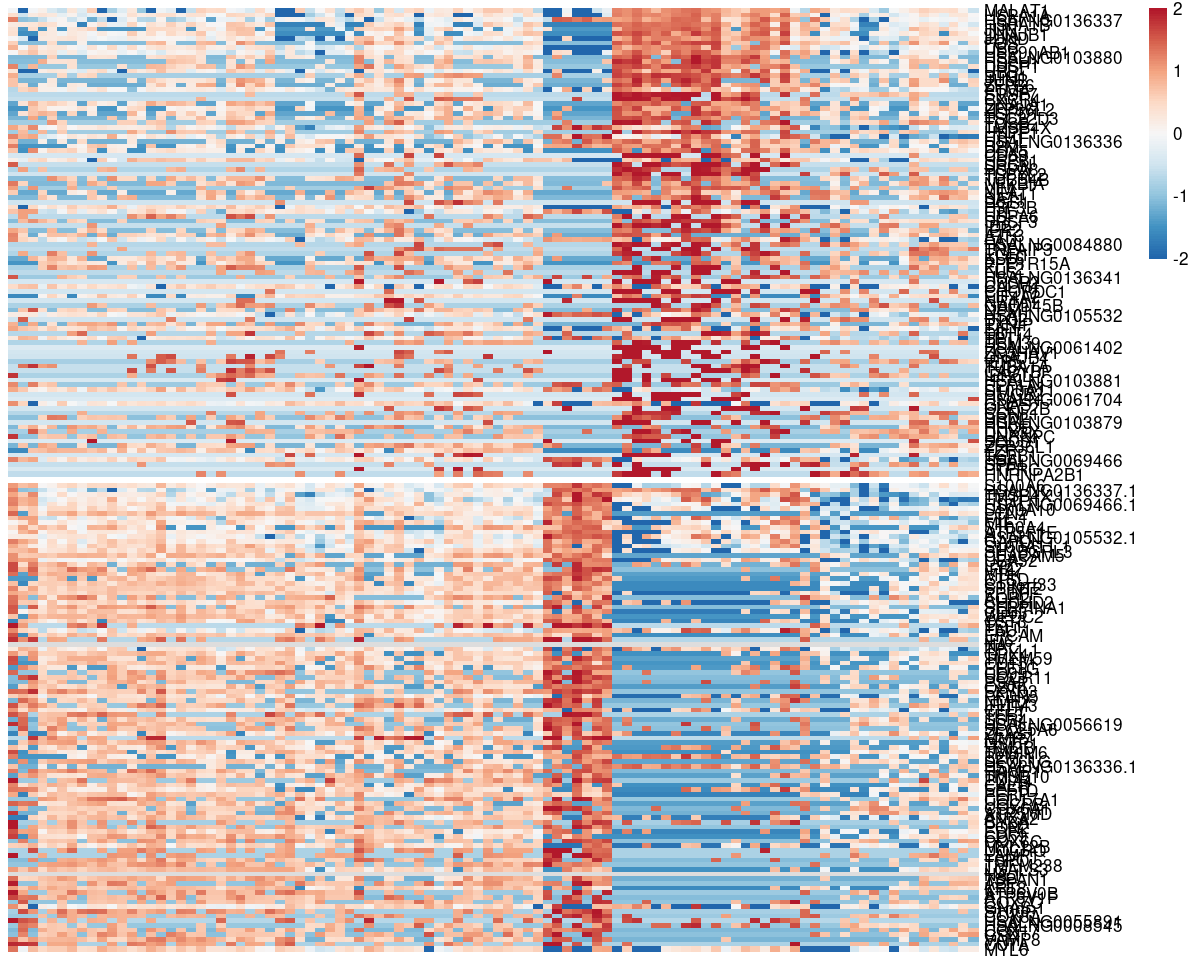

In [39]:
OneSampleHeatmap("Case2-YF.count.txt")

In [97]:
# Load the libraries
library(foreach)
library(doParallel)

# Set the number of cores you want to use
num_cores <- 40  # You can adjust this based on the available cores

# Register parallel backend
cl <- makeCluster(num_cores)
registerDoParallel(cl)

# Apply the function to the list of files in parallel
count_list <- list.files(path = ".", pattern = ".count.txt$")
foreach(i = count_list, .combine = 'rbind') %dopar% OneSampleHeatmap(i)

# Stop the parallel backend
stopCluster(cl)

result.1,Case1-YF_program_gene.heatmap.pdf
result.2,Case1-ZY_program_gene.heatmap.pdf
result.3,Case2-YF_program_gene.heatmap.pdf
result.4,Case2-ZY_program_gene.heatmap.pdf
result.5,Case3-YF_program_gene.heatmap.pdf
result.6,Case3-ZY_program_gene.heatmap.pdf
result.7,Case4-YF_program_gene.heatmap.pdf
result.8,Case4-ZY_program_gene.heatmap.pdf
result.9,Case5-YF_program_gene.heatmap.pdf
result.10,Case5-ZY_program_gene.heatmap.pdf
result.11,Case6-ZY_program_gene.heatmap.pdf


In [ ]:
# this step can be skipped.
# need long time, 
# one sample need around 3 mins. file, which have cell number > 10,000 will take longer (~1 hours)
for(i in list.files(path = ".", pattern = ".count.txt$")){
  OneSampleHeatmap(i)
}

### meta gene program annotation


In [81]:
library(tidyverse)

In [82]:
maybe.bg

[1] "PT5_4"       "Case2-YF_9"  "Case2-YF_4"  "T12_10"      "PT3_3"      
  [6] "T15_5"       "T12_4"       "T7_4"        "T23_1"       "T5_7"       
 [11] "Case5-ZY_7"  "T5_1"        "T8_8"        "T2_4"        "T9_10"      
 [16] "T11_9"       "Case5-YF_7"  "T4_1"        "T5_5"        "T12_2"      
 [21] "T16_3"       "T19_6"       "T7_5"        "T5_4"        "T15_8"      
 [26] "PT4_6"       "T17_4"       "T22_2"       "T13_10"      "Case6-ZY_10"
 [31] "LM1_4"       "T16_8"       "T2_1"        "Case1-YF_10" "T16_9"      
 [36] "Case5-YF_1"  "T24_4"       "T6_5"        "Case6-ZY_3"  "T24_10"     
 [41] "PT5_9"       "Case5-ZY_4"  "T6_9"        "Case2-YF_8"  "LM1_2"      
 [46] "Case6-ZY_9"  "T10_2"       "Case4-ZY_6"  "T24_3"       "PT4_8"      
 [51] "Case3-YF_2"  "T16_1"       "T6_8"        "T14_4"       "T3_1"       
 [56] "Case6-ZY_6"  "T20_10"      "T13_5"       "Case4-YF_4"  "Case6-ZY_5" 
 [61] "Case3-ZY_10" "T3_9"        "Case2-YF_10" "Case2-ZY_8"  "T14_2"      
 [66] "PT4_9"       "T24_8"       "T9_1"        "T17_8"       "T4_3"       
 [71] "PT3_8"       "T6_1"        "Case1-YF_5"  "T21_1"       "Case5-ZY_2" 
 [76] "T3_5"        "Case2-ZY_4"  "T20_2"       "T21_6"       "PT2_4"      
 [81] "Case3-ZY_9"  "Case1-ZY_1"  "T17_7"       "T1_10"       "T15_7"      
 [86] "Case4-ZY_8"  "PT2_9"       "T23_5"       "T3_10"       "T10_10"     
 [91] "T11_5"       "T12_7"       "PT5_7"       "T10_5"       "Case1-YF_1" 
 [96] "T17_2"       "T1_8"        "T10_1"       "T19_2"       "Case1-ZY_4" 
[101] "T18_6"       "T8_6"        "T3_4"        "T1_2"        "PT5_1"      
[106] "T7_1"        "Case4-ZY_2"  "T16_4"       "T18_10"      "T2_2"       
[111] "T21_5"       "T18_4"       "T14_1"       "T10_6"       "Case3-YF_9" 
[116] "PT1_3"       "Case2-ZY_3"  "T7_3"        "PT3_4"       "PT4_5"      
[121] "Case5-ZY_5"  "LM1_5"       "Case4-ZY_10" "Case6-ZY_4"  "PT1_7"      
[126] "T20_9"       "T2_6"        "T4_4"        "Case4-YF_1"  "T18_1"      
[131] "Case3-YF_6"  "T1_6"        "T18_2"       "T6_2"        "T20_6"      
[136] "Case3-ZY_8"  "T1_1"        "Case2-ZY_1"  "T4_5"        "Case4-YF_9" 
[141] "Case4-YF_3"  "T7_6"        "PT2_6"       "T9_9"        "T23_6"      
[146] "T19_10"      "T18_3"       "Case3-YF_10" "PT2_1"       "T19_4"      
[151] "Case4-ZY_4"  "T19_1"       "T1_4"        "T11_2"       "Case1-ZY_6" 
[156] "T15_4"       "LM1_1"       "T8_1"        "T21_8"       "T13_9"      
[161] "PT5_5"       "T14_8"       "T9_4"        "Case2-ZY_5"  "T21_4"      
[166] "T2_9"        "T22_1"       "T22_9"       "T22_8"       "T14_9"      
[171] "T11_1"       "T11_10"      "PT3_9"       "T15_2"       "T23_4"      
[176] "T12_3"       "T23_9"       "T22_4"       "PT2_10"      "Case1-ZY_7" 
[181] "Case5-ZY_10" "T13_8"       "T13_2"       "T20_8"       "T8_9"       
[186] "T3_6"        "Case1-ZY_8"  "T16_5"       "LM1_10"      "Case4-ZY_1" 
[191] "T9_8"        "T8_5"        "PT3_6"       "T24_9"       "T22_5"      
[196] "PT5_3"       "Case3-ZY_2"  "PT2_8"       "Case4-YF_8"  "T9_3"       
[201] "T21_10"      "Case3-ZY_1"  "LM1_7"       "T21_2"       "Case1-YF_4" 
[206] "T18_5"       "T19_8"       "Case1-ZY_2"  "T11_8"       "Case3-YF_4" 
[211] "PT3_1"       "T12_1"       "T20_1"       "PT4_4"       "PT3_10"     
[216] "LM1_6"       "T23_2"       "T19_3"       "PT2_2"       "Case2-YF_7" 
[221] "T13_1"       "T8_4"        "Case3-YF_8"  "T2_5"        "Case1-ZY_10"
[226] "T7_2"        "Case3-YF_5"  "T2_3"        "Case1-YF_2"  "Case4-YF_10"
[231] "T2_8"        "T11_6"       "T4_6"        "T6_4"        "T20_5"      
[236] "T8_2"        "Case2-ZY_9"  "T22_6"       "T11_4"       "T13_4"      
[241] "T1_9"        "PT2_3"       "T24_1"       "T8_3"        "T9_2"       
[246] "T19_7"       "PT5_2"       "T23_10"      "T9_6"        "PT4_3"      
[251] "LM1_8"       "T17_1"       "T3_2"        "Case3-ZY_3"  "Case4-ZY_3" 
[256] "Case4-ZY_5"  "T22_10"      "T17_6"       "T17_5"       "T21_9"      
[261] "T5_3"        "Case3-ZY_4"  "T10_7"       "C

In [83]:
# 读入基因全合并的数据
# all.score.df <- read.table("all.program_Zscore.txt", header = T, row.names = 1, sep = "\t", check.names = F, stringsAsFactors = F)
all.score.df[1:5, 1:5]
dim(all.score.df)
# 剔除MT或RP基因
all.score.df <- all.score.df[!grepl("^(MT|RP)", rownames(all.score.df)), ]
# 去除列的噪声
all.score.df <- all.score.df[, setdiff(colnames(all.score.df), maybe.bg)]
dim(all.score.df)
# 读入聚类结果
rowanno <- read.table("all.rowanno.txt", header = T, row.names = 1, sep = "\t", check.names = F, stringsAsFactors = F)
rowanno[1:5,]

,Case1-YF_1,Case1-YF_2,Case1-YF_3,Case1-YF_4,Case1-YF_5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HSALNG0000002,1.000000e-45,4.0000e-45,0.0011221926,3.000000e-45,1.486048e-03
HSALNG0000003,7.985494e-05,7.9246e-05,0.0003284086,3.796881e-04,1.000000e-45
HSALNG0000004,1.297180e-19,1.0000e-45,0.0007611891,3.351131e-04,3.000000e-45
HSALNG0000014,0.000000e+00,0.0000e+00,0.0000000000,0.000000e+00,0.000000e+00
HSALNG0000017,3.000000e-45,0.0000e+00,0.0019846520,4.000000e-45,1.000000e-45


[1] 62356   406

[1] 62132    71

,sample,study,cluster
,<chr>,<chr>,<int>
Case1-ZY_9,Case1-ZY,Case,1
Case2-YF_1,Case2-YF,Case,2
Case2-YF_2,Case2-YF,Case,3
Case2-YF_6,Case2-YF,Case,2
Case2-ZY_7,Case2-ZY,Case,4


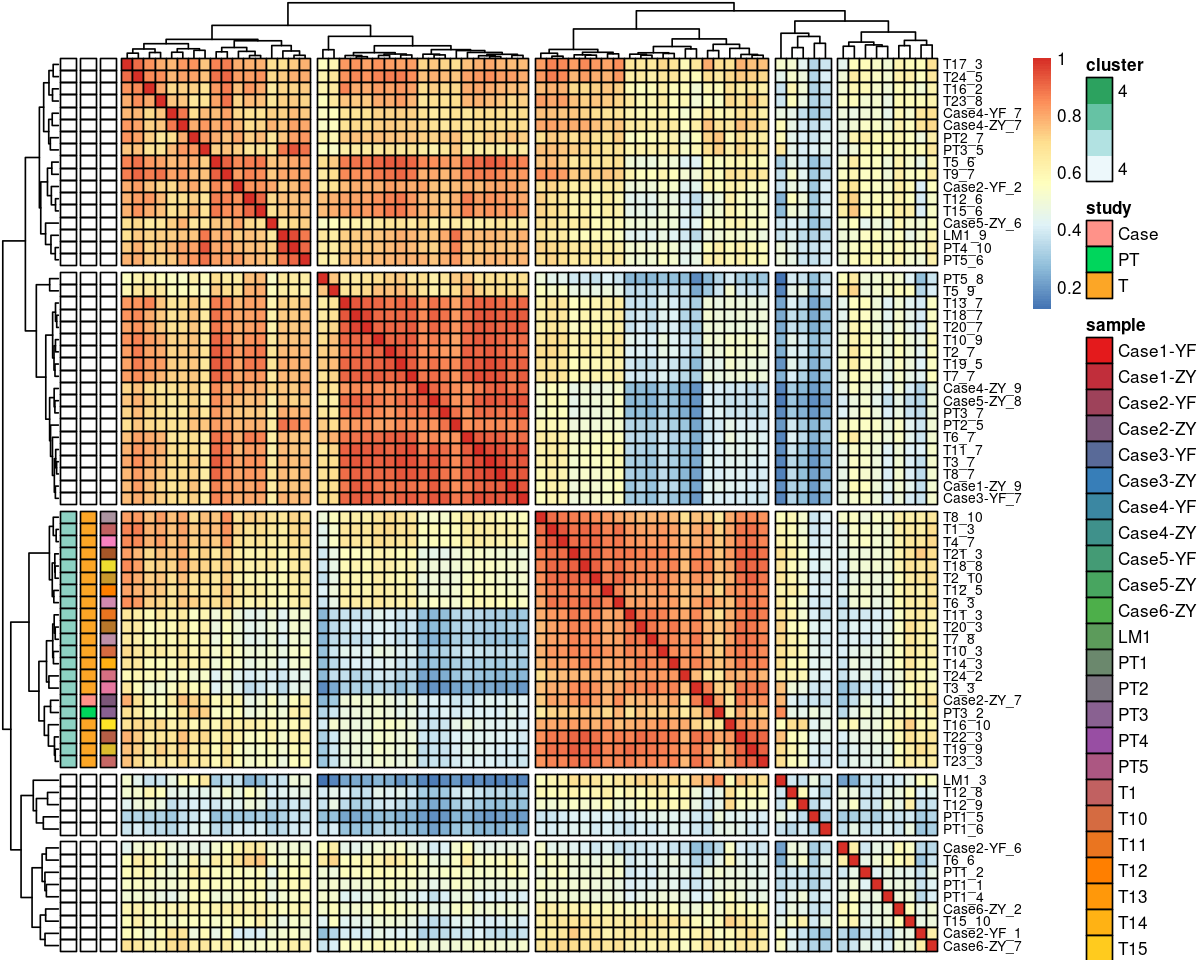

In [84]:
# 指定关注的类群，这个阶段依旧是盲选，如果可以将聚类标号直接画在图上就好了
cluster_tmp <- "4"
selected_rows <- which(cluster_data$cluster == as.numeric(cluster_tmp))
rowanno_sub <- rowanno[selected_rows, ]

pheatmap(all.score.rm.df.cor,
         cluster_rows = TRUE,
         cluster_cols = TRUE,
         cutree_rows=cluster_num,
         cutree_cols=cluster_num,
         clustering_method = "complete",
         show_colnames = FALSE,
         treeheight_row = 30,
         treeheight_col = 30,
         border_color = "black",
         annotation_row = rowanno_sub,
         annotation_names_row = FALSE,
         annotation_names_col = FALSE,
         annotation_legend = TRUE,
         annotation_colors = ann_colors,
        #  color = colorRampPalette(c("white", "yellow", "red", "#67001F"))(50),
         fontsize_row = 8,
)

In [85]:
rownames(rowanno_sub)

[1] "Case2-ZY_7" "PT3_2"      "T1_3"       "T10_3"      "T11_3"     
 [6] "T12_5"      "T14_3"      "T16_10"     "T18_8"      "T19_9"     
[11] "T2_10"      "T20_3"      "T21_3"      "T22_3"      "T23_3"     
[16] "T24_2"      "T3_3"       "T4_7"       "T6_3"       "T7_8"      
[21] "T8_10"

In [86]:
# 对于某一个模块，取出所有的基因的值，相当于从上面的热图中扣出来一小块
signature.programs=rownames(rowanno_sub)
signature.loading=all.score.df[,c(signature.programs)]
dim(signature.loading)
signature.loading[1:5,1:5]

[1] 62132    21

,Case2-ZY_7,PT3_2,T1_3,T10_3,T11_3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HSALNG0000002,2.605520e-03,4.702183e-03,0.00168864,1e-45,1.000000e-45
HSALNG0000003,0.000000e+00,3.019818e-03,0.00000000,0e+00,0.000000e+00
HSALNG0000004,1.000000e-45,3.919203e-04,0.00000000,0e+00,0.000000e+00
HSALNG0000014,8.522403e-04,0.000000e+00,0.00000000,0e+00,0.000000e+00
HSALNG0000017,7.013117e-22,1.000000e-45,0.00000000,0e+00,9.600153e-06


In [87]:
# 同样可以做相关性热图，更细致的查看
signature.loading.cor=cor(signature.loading, method = "pearson", use = "pairwise.complete.obs")

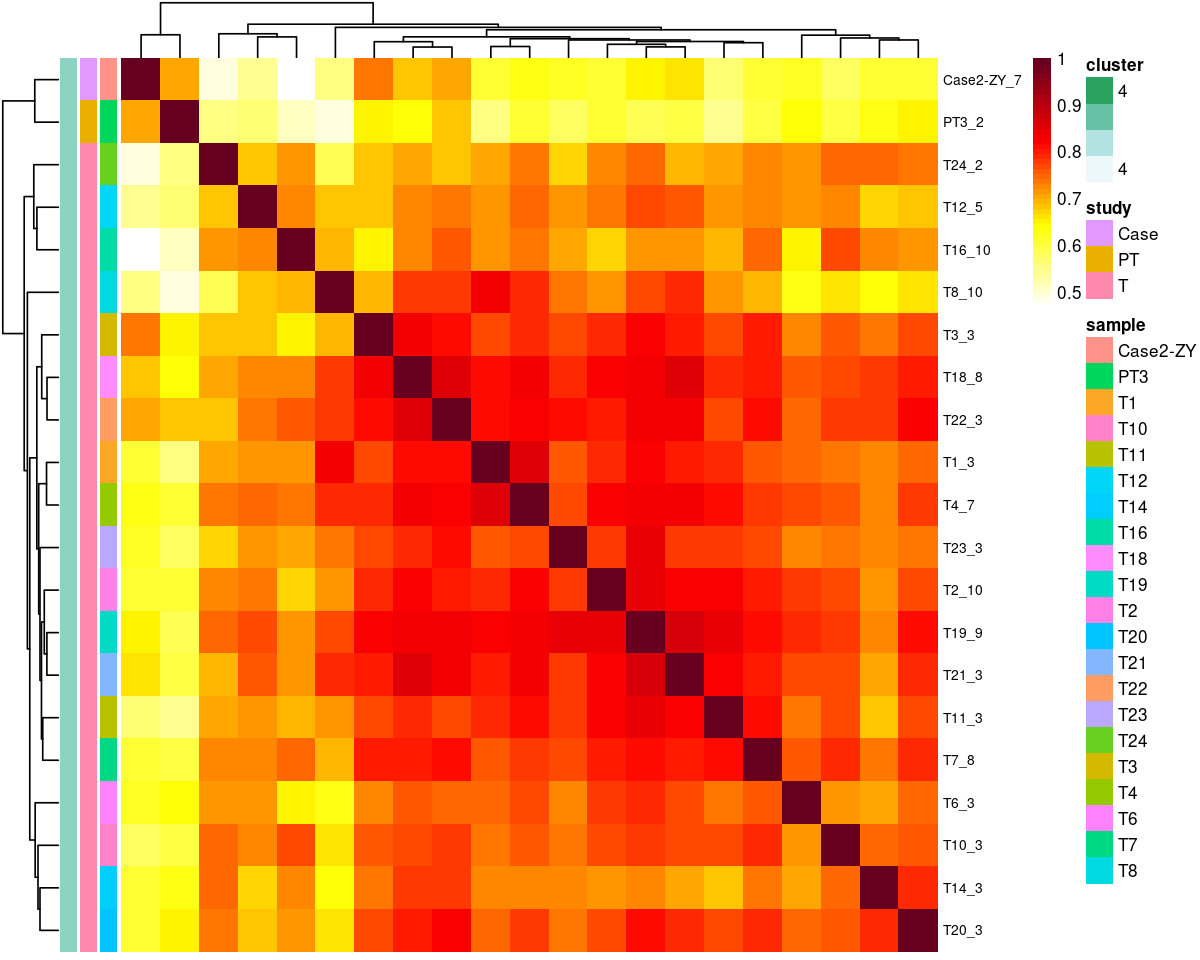

In [88]:
pheatmap(signature.loading.cor,
         cluster_rows = TRUE,
         cluster_cols = TRUE,
         #cutree_rows=cluster_num,
         #cutree_cols=cluster_num,
         clustering_method = "complete",
         show_colnames = FALSE,
         treeheight_row = 30,
         treeheight_col = 30,
         border_color = NA,
         annotation_row = rowanno_sub,
         annotation_names_row = FALSE,
         annotation_names_col = FALSE,
         annotation_legend = TRUE,
         # annotation_colors = ann_colors,
         color = colorRampPalette(c("white", "yellow", "red", "#67001F"))(50),
         fontsize_row = 8,
)

- meta gene 筛选

In [89]:
used.gene=c()
for (pi in colnames(signature.loading)) {
  tmp.df=signature.loading[,pi]
  names(tmp.df)=rownames(signature.loading)
  tmp.df=tmp.df[!is.na(tmp.df)]
  used.gene=append(used.gene,names(tail(sort(tmp.df),100)))
}
used.gene=unique(used.gene)
head(used.gene)
length(used.gene)

[1] "PPDPF"   "DDX17"   "PRSS2"   "ATF4"    "HNRNPDL" "H3F3B"

[1] 444

In [90]:
signature.loading.sub = signature.loading[rownames(signature.loading) %in% used.gene,]
signature.loading.sub[is.na(signature.loading.sub)]<-0
signature.loading.sub$total_loading = rowSums(signature.loading.sub)
signature.loading.sub$average_loading = signature.loading.sub$total_loading / ncol(signature.loading.sub)
signature.loading.sub = signature.loading.sub[order(signature.loading.sub$average_loading, decreasing = T),]
meta.gene.list = head(rownames(signature.loading.sub), 100)
meta.gene.list

[1] "MALAT1"        "HSALNG0136337" "HSALNG0136336" "HSALNG0136341"
  [5] "TMSB4X"        "S100A6"        "NEAT1"         "PTMA"         
  [9] "INS"           "LYZ"           "FTH1"          "HSALNG0105532"
 [13] "UBC"           "KRT19"         "S100A11"       "IGKC"         
 [17] "KRT8"          "HSALNG0069466" "GAPDH"         "S100A10"      
 [21] "FOS"           "ZFP36"         "CST3"          "HSPB1"        
 [25] "GNAS"          "ELF3"          "MUC1"          "MYL6"         
 [29] "ITM2B"         "IFITM3"        "TXNIP"         "IGFBP7"       
 [33] "MIF"           "KRT18"         "CFL1"          "CLDN4"        
 [37] "JUN"           "H3F3A"         "SPINT2"        "JUNB"         
 [41] "OLFM4"         "ACTB"          "ANXA2"         "TMBIM6"       
 [45] "SAT1"          "EEF1G"         "PFDN5"         "ZFP36L2"      
 [49] "PSAP"          "DDX5"          "CYBA"          "ACTN4"        
 [53] "JUND"          "HLA.DRA"       "GSN"           "B2M"          
 [57] "CEACAM6"       "SH3BGRL3"      "DDX17"         "CYP3A5"       
 [61] "DDIT4"         "IFI27"         "HSALNG0084880" "CD24"         
 [65] "MMP7"          "HNRNPA1"       "SPP1"          "FAU"          
 [69] "LMNA"          "LCN2"          "COX7C"         "ZFP36L1"      
 [73] "ATP5F1E"       "TM4SF1"        "H3F3B"         "NACA"         
 [77] "SON"           "ARGLU1"        "HMGB1"         "GCC2"         
 [81] "EEF1D"         "N4BP2L2"       "TMC5"          "HSPA1A"       
 [85] "UQCRB"         "GSTP1"         "XIST"          "CDC42"        
 [89] "IGHG4"         "TSPAN3"        "PLEC"          "IER3"         
 [93] "AHNAK"         "BTG1"          "YWHAZ"         "PRRC2C"       
 [97] "PPDPF"         "KLF6"          "HSP90AB1"      "DUSP1"

- meta gene 注释

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
MYC_TARGETS_V1,MYC_TARGETS_V1,MYC_TARGETS_V1,12/31,200/4857,1.214551e-09,2.186192e-08,1.917712e-08,RPS2/RPS6/RPS3/RPL34/RPL18/RPLP0/RPS5/RPL14/RPL6/RACK1/EEF1B2/RPL22,12
ALLOGRAFT_REJECTION,ALLOGRAFT_REJECTION,ALLOGRAFT_REJECTION,6/31,200/4857,1.404656e-03,1.264190e-02,1.108939e-02,RPS19/RPL39/RPS3A/B2M/RPL9/RPS9,6


wrong orderBy parameter; set to default `orderBy = "x"`



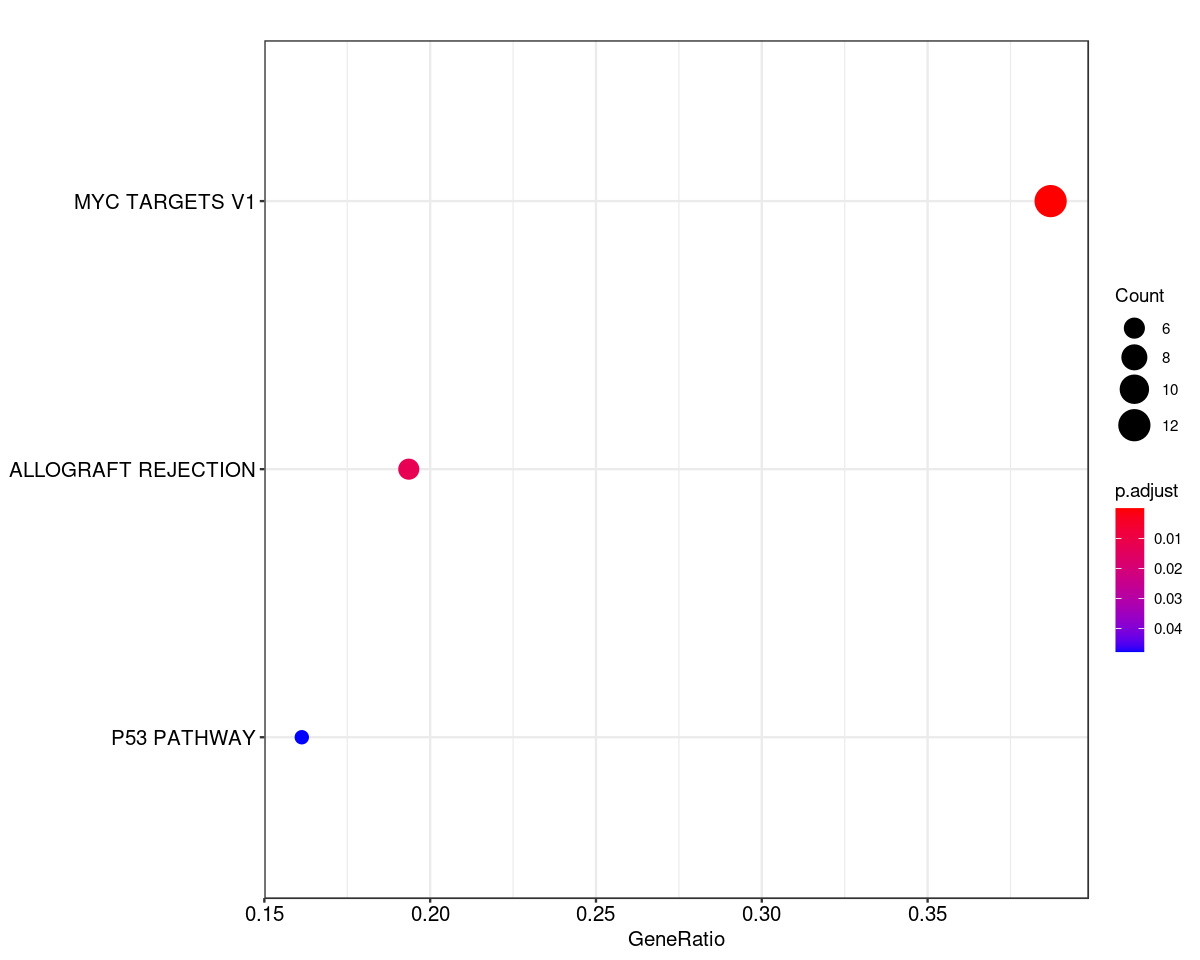

In [235]:
# KEGG
hsets.kegg <- read.gmt("/public/workspace202011/pancancer/chaohy/gmt/hallmark_cancersea.gmt")
tmp <- enricher(meta.gene.list, TERM2GENE = hsets.kegg, pvalueCutoff = 0.05, pAdjustMethod = "BH", qvalueCutoff = 0.05, minGSSize = 1, maxGSSize = 500)
tmp@result %>% head(2)
dotplot(tmp)

In [242]:
# GSEA
hsets.gsea <- gmtPathways("/public/workspace202011/pancancer/chaohy/gmt/hallmark_cancersea.gmt")
meta.gene.score = signature.loading.sub$average_loading
names(meta.gene.score) = rownames(signature.loading.sub)
fgseaRes <- fgsea(hsets.gsea, meta.gene.score, minSize = 1, maxSize = 500, nproc = 4, scoreType = "pos")
fgseaRes[fgseaRes$padj < 0.05 & abs(fgseaRes$NES) > 1,] # 基本上没有怎么办？
fgseaRes[order(fgseaRes$NES, decreasing = TRUE),] %>% head(10)

pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>


pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
ALLOGRAFT_REJECTION,0.01173245,0.7156797,0.38073040,0.7696897,1.3203350,20,"RPS19, RPL39, RPS3A, B2M , RPL9 , RPS9 , NPM1"
DNA repair,0.36663337,1.0000000,0.05998925,0.7028689,1.2382096,3,"RPS27A, UBA52 , HMGB1"
MYC_TARGETS_V1,0.14585415,1.0000000,0.11056472,0.6644576,1.1519447,30,"RPS2 , RPS6 , RPS3 , RPL34 , RPL18 , RPLP0 , RPS5 , RPL14 , RPL6 , RACK1 , EEF1B2 , RPL22 , HSP90AB1, NPM1 , PABPC1 , PPIA , HNRNPA1 , RPS10"
BILE_ACID_METABOLISM,0.42157842,1.0000000,0.05345721,0.5632653,1.1480817,1,PRDX5
Apoptosis,0.48351648,1.0000000,0.04716425,0.6311602,1.0936216,4,"KRT8, GSN"
DNA damage,0.40159840,1.0000000,0.05571042,0.6461907,1.0926740,10,"RPS3 , RPS27A, UBA52 , NPM1 , UBC , UBB"
Stemness,0.42557443,1.0000000,0.05302125,0.6209974,1.0594936,18,"EEF1A1, PTMA , MALAT1, H3F3B , PABPC1"
MYC_TARGETS_V2,0.50349650,1.0000000,0.04531524,0.5963115,1.0504927,3,"NPM1 , HSPD1, HSPE1"
ANDROGEN_RESPONSE,0.55044955,1.0000000,0.04123761,0.6055112,1.0368990,7,"B2M , KRT8 , KRT19 , SAT1 , MYL12A"


- 批量注释

In [290]:
hsets.gsea <- gmtPathways("/public/workspace202011/pancancer/chaohy/gmt/hallmark_cancersea.gmt")

rowanno_all = data.frame()
for (i in unique(cluster_data$cluster)){
cluster_tmp <- i
selected_rows <- which(cluster_data$cluster == as.numeric(cluster_tmp))
rowanno_sub <- rowanno[selected_rows, ]
signature.programs=rownames(rowanno_sub)
signature.loading=all.score.df[,c(signature.programs)]

used.gene=c()
for (pi in colnames(signature.loading)) {
  tmp.df=signature.loading[,pi]
  names(tmp.df)=rownames(signature.loading)
  tmp.df=tmp.df[!is.na(tmp.df)]
  used.gene=append(used.gene,names(tail(sort(tmp.df),100)))
}
used.gene=unique(used.gene)
signature.loading.sub = signature.loading[rownames(signature.loading) %in% used.gene,]
signature.loading.sub[is.na(signature.loading.sub)]<-0
signature.loading.sub$total_loading = rowSums(signature.loading.sub)
signature.loading.sub$average_loading = signature.loading.sub$total_loading / ncol(signature.loading.sub)
signature.loading.sub = signature.loading.sub[order(signature.loading.sub$average_loading, decreasing = T),]
meta.gene.list = head(rownames(signature.loading.sub), 100)
# 存储每个meta program的基因列表
write.table(meta.gene.list,file = paste("cluster",i,"_meta_gene_list.txt",sep = ""),quote = F,sep = "\t",row.names = F,col.names = T)
meta.gene.score = signature.loading.sub$average_loading
names(meta.gene.score) = rownames(signature.loading.sub)
fgseaRes <- fgsea(hsets.gsea, meta.gene.score, minSize = 1, maxSize = 500, nproc = 4, scoreType = "pos")
gsea_result = fgseaRes[order(fgseaRes$NES, decreasing = TRUE),] %>% head(1)

rowanno_sub$gsea = gsea_result$pathway

rowanno_all = rbind(rowanno_all, rowanno_sub)
}

In [98]:
unique(rowanno_all$gsea)

[1] "CHOLESTEROL_HOMEOSTASIS" "APICAL_SURFACE"         
[3] "DNA damage"              "PANCREAS_BETA_CELLS"    
[5] "Stemness"

In [112]:
library(viridis)

png 
  2

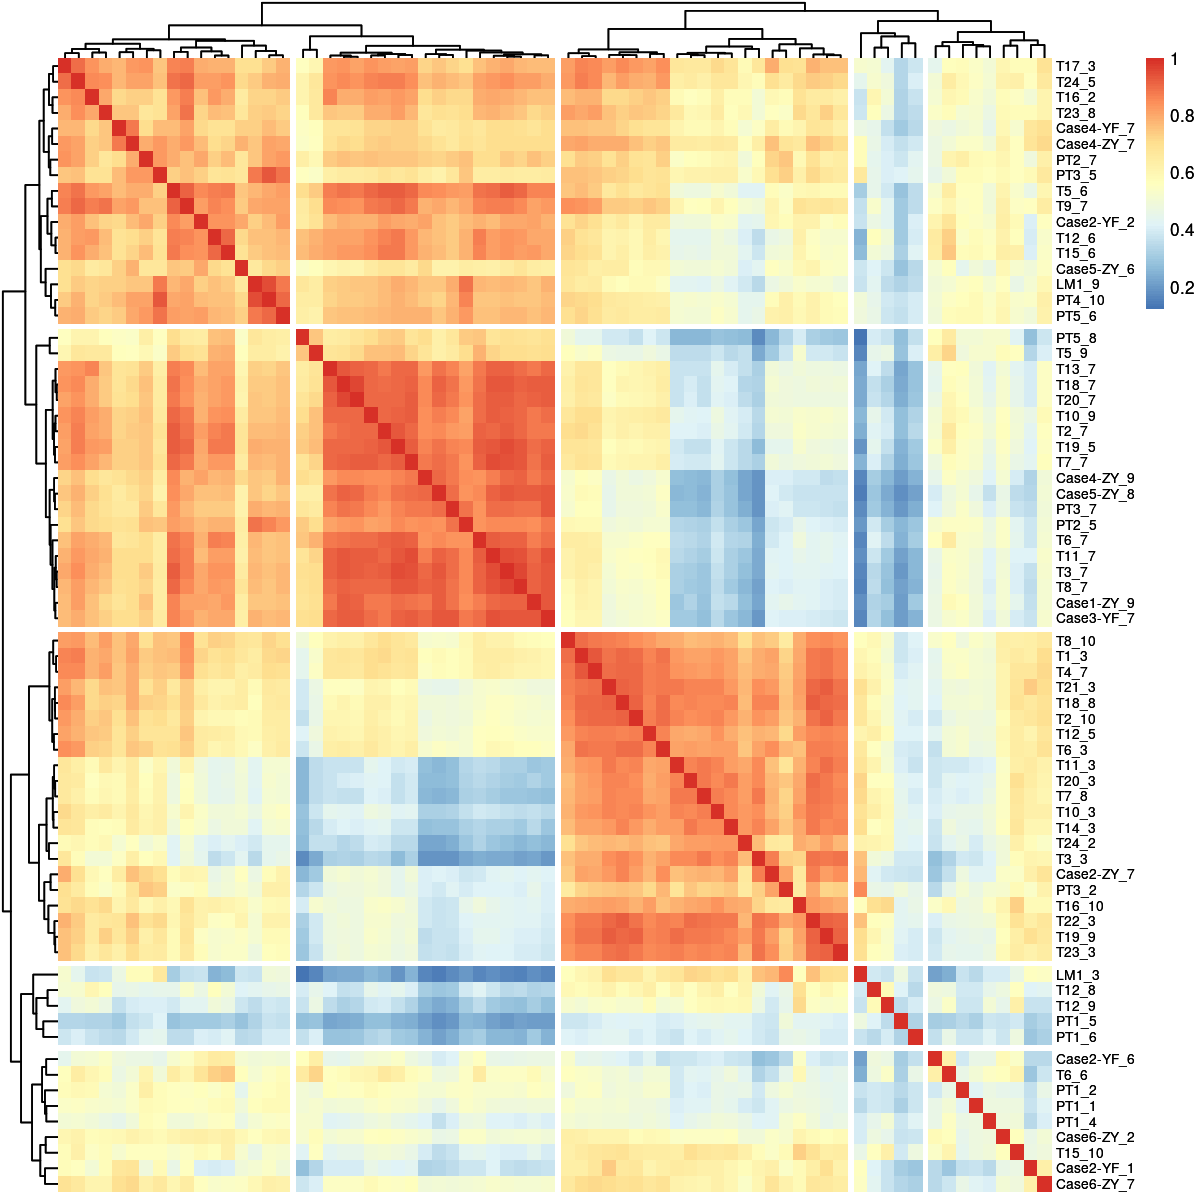

In [291]:
options(repr.plot.width=10, repr.plot.height=10)
pheatmap(all.score.rm.df.cor,
         cluster_rows = TRUE,
         cluster_cols = TRUE,
         cutree_rows=cluster_num,
         cutree_cols=cluster_num,
         clustering_method = "complete",
         show_colnames = FALSE,
         show_rownames = T,
         treeheight_row = 30,
         treeheight_col = 30,
         border_color = "NA",
        #  annotation_row = rowanno_all,
         annotation_names_row = FALSE,
         annotation_names_col = FALSE,
         annotation_legend = TRUE,
        #  annotation_colors = ann_colors,
        #  color = turbo(100),
         fontsize_row = 8,
) -> tmpp
tmpp
pdf("/public/workspace202011/pancancer/chaohy/joLncPDAC/countK10/nmf_heatmap.pdf", width = 10, height = 10)
tmpp
dev.off()

In [292]:
library(clusterProfiler)

MetaGene <- function(program){
  cluster_tmp <- rowanno[rownames(rowanno) == program, colnames(rowanno) == "cluster"] 
  print(paste("cluster", cluster_tmp, sep = ""))
  selected_rows <- which(cluster_data$cluster == as.numeric(cluster_tmp))
  rowanno_sub <- rowanno[selected_rows, ]
  signature.programs=rownames(rowanno_sub)
  signature.loading=all.score.df[,c(signature.programs)]

  used.gene=c()
  for (pi in colnames(signature.loading)) {
    tmp.df=signature.loading[,pi]
    names(tmp.df)=rownames(signature.loading)
    tmp.df=tmp.df[!is.na(tmp.df)]
    used.gene=append(used.gene,names(tail(sort(tmp.df),100)))
  }
  used.gene=unique(used.gene)
  signature.loading.sub = signature.loading[rownames(signature.loading) %in% used.gene,]
  signature.loading.sub[is.na(signature.loading.sub)]<-0
  signature.loading.sub$total_loading = rowSums(signature.loading.sub)
  signature.loading.sub$average_loading = signature.loading.sub$total_loading / ncol(signature.loading.sub)
  signature.loading.sub = signature.loading.sub[order(signature.loading.sub$average_loading, decreasing = T),]
  meta.gene.list = head(rownames(signature.loading.sub), 100)
  # 存储每个存储每个meta program的基因列表
  write.table(meta.gene.list,file = paste("cluster",cluster_tmp,"_meta_gene_list.txt",sep = ""),quote = F,sep = "\t",row.names = F,col.names = T)
  return(meta.gene.list)
}


MetaGene("T17_3")
MetaGene("T7_7")
MetaGene("T1_3")
MetaGene("PT1_5")
MetaGene("PT1_4")

[1] "cluster3"


[1] "S100A6"        "HSALNG0136337" "TMSB4X"        "FTH1"         
  [5] "MALAT1"        "FTL"           "S100A11"       "HSALNG0136336"
  [9] "PTMA"          "HSALNG0105532" "B2M"           "GAPDH"        
 [13] "ATP5F1E"       "FAU"           "MIF"           "S100A10"      
 [17] "TPT1"          "HSALNG0069466" "IFITM3"        "UBA52"        
 [21] "EEF1A1"        "MYL6"          "PPDPF"         "ACTB"         
 [25] "SH3BGRL3"      "PFDN5"         "H3F3A"         "CFL1"         
 [29] "EEF1G"         "EEF1D"         "S100A4"        "RACK1"        
 [33] "COX7C"         "NME2"          "GSTP1"         "CYBA"         
 [37] "HSALNG0094115" "LYZ"           "CST3"          "ITM2B"        
 [41] "IFI27"         "UBC"           "TMSB10"        "LRRC75A.AS1"  
 [45] "ATP5MG"        "ANXA2"         "MYL12A"        "MYL12B"       
 [49] "UQCRB"         "CHCHD2"        "HSALNG0113240" "NACA"         
 [53] "FOS"           "LCN2"          "HSALNG0136338" "HNRNPA1"      
 [57] "HSALNG0066023" "YBX1"          "NPM1"          "EIF1"         
 [61] "UBB"           "HSPB1"         "HSALNG0136341" "HSALNG0056619"
 [65] "H3F3B"         "C19orf33"      "VIM"           "PFN1"         
 [69] "HSP90AB1"      "MMP7"          "TXNIP"         "NEAT1"        
 [73] "SSR4"          "OST4"          "BTG1"          "CLIC1"        
 [77] "HSALNG0008545" "SLC25A6"       "PSAP"          "JUNB"         
 [81] "ACTG1"         "DDX5"          "COX6A1"        "HLA.A"        
 [85] "TFF1"          "ELOB"          "JUN"           "CD63"         
 [89] "KRT19"         "ATP5MD"        "SERPINA1"      "BTF3"         
 [93] "HSALNG0089742" "UBL5"          "GABARAP"       "EDF1"         
 [97] "ZFAS1"         "CALM1"         "DUSP1"         "EEF1B2"

[1] "cluster1"


[1] "FTH1"          "FTL"           "S100A6"        "HSALNG0069466"
  [5] "TMSB4X"        "GAPDH"         "FAU"           "RACK1"        
  [9] "TPT1"          "PTMA"          "MALAT1"        "NACA"         
 [13] "EEF1G"         "LRRC75A.AS1"   "MIF"           "UBA52"        
 [17] "ATP5F1E"       "HSALNG0094115" "EEF1A1"        "HSALNG0105532"
 [21] "HSALNG0008545" "PPDPF"         "NME2"          "EEF1D"        
 [25] "ZFAS1"         "COX7C"         "EEF1B2"        "PFDN5"        
 [29] "S100A11"       "C19orf33"      "EIF1"          "S100A10"      
 [33] "NPM1"          "UQCRB"         "TMSB10"        "MYL6"         
 [37] "YBX1"          "HSALNG0056619" "ATP5MC2"       "GSTP1"        
 [41] "HNRNPA1"       "HSALNG0136337" "BTF3"          "HSALNG0113240"
 [45] "H3F3A"         "ATP5MG"        "CHCHD2"        "ANXA2"        
 [49] "SLC25A6"       "HINT1"         "LGALS3"        "KRT19"        
 [53] "OST4"          "SNHG6"         "ACTG1"         "HSALNG0074365"
 [57] "EIF3H"         "IFITM3"        "ELOB"          "SNRPD2"       
 [61] "HSP90AB1"      "NOP53"         "SNHG5"         "KRT18"        
 [65] "CFL1"          "MYL12B"        "MYL12A"        "H3F3B"        
 [69] "COX6B1"        "UBC"           "IFI27"         "B2M"          
 [73] "TMEM258"       "COX6C"         "ACTB"          "SUMO2"        
 [77] "HSALNG0067660" "AGR2"          "COX6A1"        "LDHA"         
 [81] "EIF4A2"        "ATP5MD"        "GPX4"          "TPI1"         
 [85] "TXN"           "SEC61G"        "S100A4"        "UBB"          
 [89] "HSPB1"         "SH3BGRL3"      "EDF1"          "PABPC1"       
 [93] "UBL5"          "UQCR11"        "PPIA"          "INS"          
 [97] "COX8A"         "GABARAP"       "CST3"          "LGALS4"

[1] "cluster4"


[1] "MALAT1"        "HSALNG0136337" "HSALNG0136336" "HSALNG0136341"
  [5] "TMSB4X"        "S100A6"        "NEAT1"         "PTMA"         
  [9] "INS"           "LYZ"           "FTH1"          "HSALNG0105532"
 [13] "UBC"           "KRT19"         "S100A11"       "IGKC"         
 [17] "KRT8"          "HSALNG0069466" "GAPDH"         "S100A10"      
 [21] "FOS"           "ZFP36"         "CST3"          "HSPB1"        
 [25] "GNAS"          "ELF3"          "MUC1"          "MYL6"         
 [29] "ITM2B"         "IFITM3"        "TXNIP"         "IGFBP7"       
 [33] "MIF"           "KRT18"         "CFL1"          "CLDN4"        
 [37] "JUN"           "H3F3A"         "SPINT2"        "JUNB"         
 [41] "OLFM4"         "ACTB"          "ANXA2"         "TMBIM6"       
 [45] "SAT1"          "EEF1G"         "PFDN5"         "ZFP36L2"      
 [49] "PSAP"          "DDX5"          "CYBA"          "ACTN4"        
 [53] "JUND"          "HLA.DRA"       "GSN"           "B2M"          
 [57] "CEACAM6"       "SH3BGRL3"      "DDX17"         "CYP3A5"       
 [61] "DDIT4"         "IFI27"         "HSALNG0084880" "CD24"         
 [65] "MMP7"          "HNRNPA1"       "SPP1"          "FAU"          
 [69] "LMNA"          "LCN2"          "COX7C"         "ZFP36L1"      
 [73] "ATP5F1E"       "TM4SF1"        "H3F3B"         "NACA"         
 [77] "SON"           "ARGLU1"        "HMGB1"         "GCC2"         
 [81] "EEF1D"         "N4BP2L2"       "TMC5"          "HSPA1A"       
 [85] "UQCRB"         "GSTP1"         "XIST"          "CDC42"        
 [89] "IGHG4"         "TSPAN3"        "PLEC"          "IER3"         
 [93] "AHNAK"         "BTG1"          "YWHAZ"         "PRRC2C"       
 [97] "PPDPF"         "KLF6"          "HSP90AB1"      "DUSP1"

[1] "cluster5"


[1] "MALAT1"        "HSALNG0136337" "HSALNG0136336" "S100A6"       
  [5] "HSALNG0136338" "HSALNG0066023" "HSALNG0089742" "TMSB4X"       
  [9] "KRT8"          "TFF1"          "KRT19"         "PTMA"         
 [13] "KRT18"         "TPM1"          "HSPB1"         "HSALNG0105532"
 [17] "GSTP1"         "MMP7"          "PMEPA1"        "LGALS3"       
 [21] "ANXA2"         "DEFB1"         "GPX2"          "GKN1"         
 [25] "TFF2"          "NEAT1"         "HSALNG0136341" "S100A11"      
 [29] "CST3"          "KRT17"         "SPP1"          "SON"          
 [33] "S100A10"       "DDX5"          "IFI27"         "SERPINA1"     
 [37] "GAPDH"         "FTH1"          "LCN2"          "AHNAK"        
 [41] "CD24"          "CFL1"          "UBC"           "TXN"          
 [45] "GKN2"          "AGR2"          "TSPAN8"        "HLA.A"        
 [49] "PLEC"          "SOX4"          "MYL6"          "TPT1"         
 [53] "CD59"          "PPDPF"         "MDK"           "MUC1"         
 [57] "HSALNG0084880" "H3F3A"         "SUMO2"         "HSP90AB1"     
 [61] "TMBIM6"        "VIM"           "DST"           "CEACAM6"      
 [65] "SPINT2"        "CYP3A5"        "EZR"           "DUOX2"        
 [69] "YWHAZ"         "PRDX1"         "MYH9"          "SPATS2L"      
 [73] "ACTB"          "HSALNG0106470" "OLFM4"         "AKR1C3"       
 [77] "AKR1B10"       "SAT1"          "TACSTD2"       "DSP"          
 [81] "FOS"           "CTNND1"        "SPTBN1"        "B2M"          
 [85] "GTF2I"         "TMSB10"        "PERP"          "CTSB"         
 [89] "DYNC1H1"       "SPINK1"        "ACTN4"         "EEF1A1"       
 [93] "LGALS4"        "YWHAB"         "CYBA"          "GSN"          
 [97] "JPT1"          "DUOXA2"        "SQSTM1"        "MYH14"

[1] "cluster2"


[1] "HSALNG0136337" "MALAT1"        "S100A6"        "TMSB4X"       
  [5] "PTMA"          "S100A11"       "S100A10"       "FTH1"         
  [9] "KRT19"         "HSALNG0105532" "HSALNG0136336" "HSPB1"        
 [13] "FTL"           "KRT18"         "UBC"           "ATP5F1E"      
 [17] "PPDPF"         "CST3"          "B2M"           "SH3BGRL3"     
 [21] "ACTB"          "TFF1"          "C19orf33"      "TPT1"         
 [25] "AGR2"          "MIF"           "MYL6"          "LYZ"          
 [29] "ANXA2"         "H3F3A"         "LGALS3"        "CD24"         
 [33] "FAU"           "HSPA1A"        "GSTP1"         "TXN"          
 [37] "JUND"          "KRT8"          "EEF1A1"        "CEACAM6"      
 [41] "GAPDH"         "MYL12B"        "FXYD3"         "MUC1"         
 [45] "FOS"           "IFI27"         "ELOB"          "LGALS4"       
 [49] "TSPO"          "HSP90AB1"      "WFDC2"         "HSALNG0136341"
 [53] "TFF2"          "YWHAZ"         "EEF1D"         "UBB"          
 [57] "TSPAN8"        "LCN2"          "ITM2B"         "SPINT2"       
 [61] "BTG1"          "MYL12A"        "CD63"          "SMIM22"       
 [65] "CHCHD2"        "C15orf48"      "JUNB"          "S100A4"       
 [69] "CEACAM5"       "ATP5MD"        "ACTG1"         "PHLDA2"       
 [73] "COX6B1"        "COX7C"         "CFL1"          "TACSTD2"      
 [77] "H3F3B"         "JUN"           "IFITM3"        "PSCA"         
 [81] "PRDX1"         "RAC1"          "HSPA1B"        "HSALNG0082038"
 [85] "UQCRQ"         "ATP6V0C"       "ZFP36L2"       "EZR"          
 [89] "HSALNG0069466" "S100A13"       "DYNLL1"        "CALM1"        
 [93] "NACA"          "LY6E"          "NQO1"          "RACK1"        
 [97] "EPCAM"         "NEAT1"         "ELF3"          "HSALNG0136338"

[1] "cluster2"


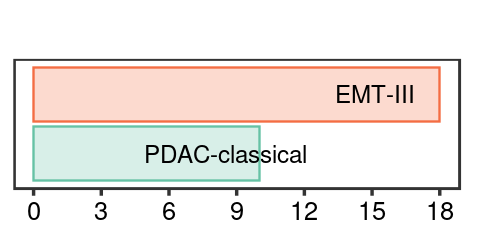

In [299]:
MetaGene("PT1_4") -> meta.gene.list
pathway2gene <- read.table("/public/workspace202011/pancancer/chaohy/joLncPDAC/metaPrograme/pathway2gene",header = T,sep = "\t")
pathway2name <- read.table("/public/workspace202011/pancancer/chaohy/joLncPDAC/metaPrograme/pathway2name",header = T,sep = "\t")
MP <- enricher(meta.gene.list, 
                TERM2GENE = pathway2gene, 
                TERM2NAME = pathway2name, 
                pvalueCutoff = 1,  # 表示全部保留，可以设为0.05作为阈值
                qvalueCutoff = 1, # 表示全部保留，可以设为0.05作为阈值
                pAdjustMethod = "BH",
                minGSSize = 1)
MP_df <- as.data.frame(MP@result)
MP_df <- MP_df[order(MP_df$Count,decreasing = T),]
MP_df <- MP_df %>% head(2) %>% mutate(Description = fct_reorder(Description, Count))
options(repr.plot.width=4, repr.plot.height=2)
ggplot(MP_df, aes(x = Count, y = Description)) +
  geom_bar(stat = "identity", fill = c("#fcdacf","#d8efe8"),color=c("#f46d43","#66c2a5")) +
  geom_text(aes(label = Description), position = position_stack(0.85), size = 5)+
  theme_bw(base_size = 16, base_rect_size = 1) +
  scale_y_discrete(position = "right") +
  theme(axis.text = element_text(size = 15, color = "black")) +
  labs(x = "Meta-genes number", y = "Meta-programs", title = "") +
  guides(size = FALSE)+
  theme(axis.text = element_text(size = 15, color = "black"),
        axis.title.y = element_blank(),  # 隐藏默认 Y 轴标题
        axis.title.x = element_blank(),  # 隐藏默认 X 轴标题
        axis.line.y = element_blank(),    # 隐藏默认 Y 轴线
        axis.ticks.y = element_blank(),   # 隐藏默认 x 轴刻度
        axis.line.x = element_blank(),    # 隐藏默认 x 轴线
        axis.text.y = element_blank(),
        panel.grid.major.y = element_blank(),  # 隐藏 Y 轴主要网格线
        panel.grid.minor.y = element_blank(),
        panel.grid.major.x = element_blank(),  # 隐藏 Y 轴主要网格线
        panel.grid.minor.x = element_blank())+
  scale_x_continuous(breaks = seq(0, max(MP_df$Count), by = 3)) -> p1
p1


png 
  2

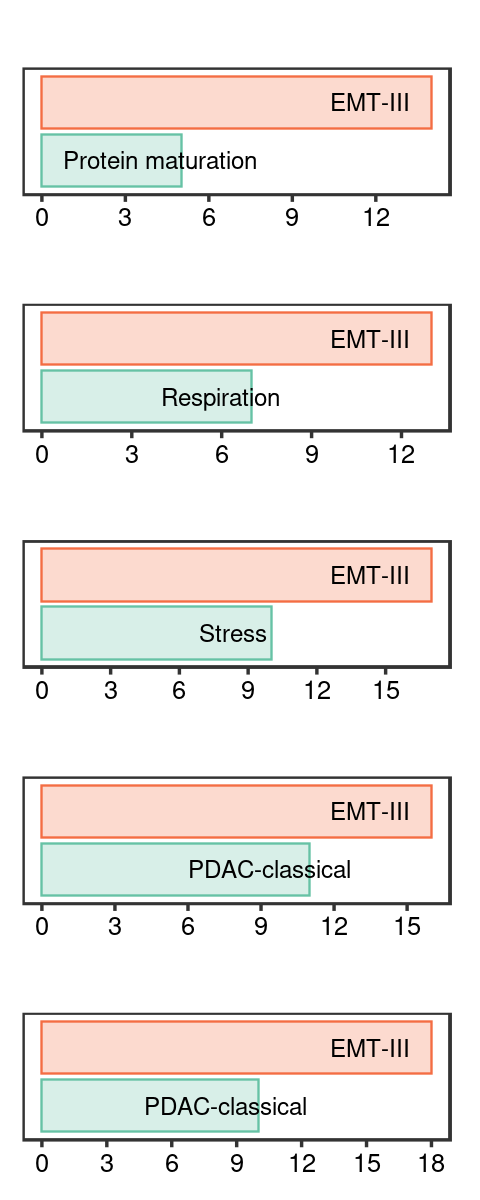

In [300]:
options(repr.plot.width=4, repr.plot.height=10)
p1/p2/p3/p4/p5
pdf("/public/workspace202011/pancancer/chaohy/joLncPDAC/metaPrograme/metaPrograme.pdf", width = 4, height = 10)
p1/p2/p3/p4/p5
dev.off()